# <font color='red'>Examen Data Science</font>

![title](img/st.jpeg)

Escribir su Nombre y Apellido a continuación

Nombre: Diego Demian
Apellido: Vallejos

# Sección A - Desafíos Técnicos

## <font color='red'>1 -Python</font>

### py-1) Vectores, Clases y Objetos

Desarrollar una clase en python que, al instanciar, reciba un vector **weights** y que tenga la siguiente funcionalidad:


* Desarrollar el método **set_weights** que pueda sobrescribir los valores del atributo `weights`
* Desarrollar el método **dot** que permita multiplicar el vector `weigths` por un vector de entrada. (producto escalar)
* Desarrollar el método **predict** que utilice la salida del método dot y lo pasé por la función ReLu. <a href=https://es.wikipedia.org/wiki/Rectificador_(redes_neuronales)>Función Relu</a>  
* Desarrollar otra clase que herede el comportamiento de la clase anterior y que además:
  * Reciba un parametro adicional: `bias` (int64)
  * Redefina el método **dot** y al producto le sume el atributo `bias`

In [99]:
import numpy as np
weights = np.array([-4,3,1,-2])

In [121]:
# Escriba aquí su respuesta

class Model(): #Sin bias
    def __init__(self, weights):
        self.weights = weights

    def set_weights(self, weights):
        self.weights = weights

    def dot(self, x):
        return np.dot(self.weights, x)
    
    def predict(self, x):
        return np.maximum(0, self.dot(x))
    

class Biased_Model(Model):
    def __init__(self, weights, bias: int):
        super().__init__(weights)
        self.bias = bias

    def dot(self, x):
        return np.dot(self.weights, x) + self.bias

def relu(X):
   return np.maximum(0,X)

### py-2) Unit test

Desarrollar un test unitario que permita evaluar los métodos de la clase base. 

In [122]:
# Escriba aquí su respuesta
import unittest

class TestModel(unittest.TestCase):
    def setUp(self):
        self.weights_array = np.array([1, 2, 3])
        self.test_weights = Model(self.weights_array)

    def test_set_weights(self):
        new_weights = np.array([1,2,3])
        self.test_weights.set_weights(new_weights)
        np.testing.assert_array_equal(self.test_weights.weights, new_weights)

    def test_dot(self):
        x = np.array([4,5,6])
        expected_result = np.dot(self.weights_array, x)
        self.assertEqual(self.test_weights.dot(x), expected_result)

    def test_predict_positive(self):
        x = np.array([1, 1, 1])
        expected_result = np.maximum(0, np.dot(self.weights_array, x))
        self.assertEqual(self.test_weights.predict(x), expected_result)

    def test_predict_negative(self):
        x = np.array([-1, -1, -1])
        expected_result = np.maximum(0, np.dot(self.weights_array, x))
        self.assertEqual(self.test_weights.predict(x), expected_result)


In [123]:
test = TestModel()
test.setUp()
test.test_set_weights()
test.test_dot()
test.test_predict_positive()
test.test_predict_negative()

## <font color='red'>2- SQL</font>

Para el siguiente ejercicio se tiene una base de datos que tiene el siguiente DER:

![title](img/img_der.png)


* Persona (id) puede tener muchas Tarjetas (se relaciona a través de `id_titular`)
* Una Compra siempre es realizada con una única tarjeta
* (EXTRA) La tabla Compra posee un histórico de más de 10 años y varias decenas de millones de registros por lo que las consultas a esta entidad pueden tardar varios minutos si no están correctamente optimizadas.

### sql-1) Query

Obtener los número de tarjeta que no tengan consumos en el último mes pero que pertenecen a personas que hayan comprado al menos un total de $5000 en el último mes en los rubros (FARMACIA y SUPERMERCADOS) en conjunto. (Si es posible, tener en cuenta el punto EXTRA mencionado previamente).


In [109]:
# Escriba aquí su respuesta
print(' Cuando tenemos una tabla con muchos registros lo mejor es crear un index para poder acceder a los datos de manera más rápida.')

query_respuesta = """
CREATE INDEX idx_compra_fecha_compra ON compra(fecha_compra);
CREATE INDEX idx_compra_nro_tarjeta ON compra(nro_tarjeta);
CREATE INDEX idx_compra_rubro ON compra(rubro);
CREATE INDEX idx_tarjeta_nro_tarjeta ON tarjeta(nro_tarjeta);
CREATE INDEX idx_tarjeta_id_titular ON tarjeta(id_titular);



WITH tarjetas_sin_compras_utlimo_mes AS (
SELECT t.nro_tarjeta 
FROM Tarjetas AS t
LEFT JOIN (SELECT nro_tarjeta FROM compra WHERE fecha_compra >= DATEADD(MONTH, -1, GETDATE())) AS c
ON t.nro_tarjeta = c.nro_tarjeta
WHERE c.nro_tarjeta IS NULL
)

#Hasta aca creamos indices para las tablas de compra y tarjeta, para poder acceder a los datos de manera mas eficiente. Luego creamos una tabla temporal que nos trae los numeros de tarjeta que no realizaron compras en el ultimo mes.
#Siendo la logica a utilizar hacer un Left Join (que trae los registros que se encuenten en la tabla de la "izquiera" y las coincidentes de la tabla de la "derecha"), esto genera que tengamos ahora todos los numeros de tarjeta
# y solo los que realizaron compras en el ultimo mes. Luego filtramos los que no realizaron compras en el ultimo mes (donde el campo numero de tarjeta es nulo).

SELECT tsc.nro_tarjeta
FROM tarjetas_sin_compras_ultimo_mes tsc
INNER JOIN Tarjetas t ON tsc.nro_tarjeta = t.nro_tarjeta
INNER JOIN (
SELECT t.id_titular
FROM Compra AS c
INNER JOIN Tarjeta AS t ON C.nro_tarjeta = t.nro_tarjeta
WHERE c.fecha_compra >= DATEADD(MONTH, -1, GETDATE())
AND c.rubro IN ('FARMACIA', 'SUPERMERCADO')
GROUP BY t.id_titular
HAVING SUM(c.monto) > 5000
) AS ct ON t.id_titular = ct.id_titular;

#Esta parte es la de la query principal, aca me traigo los numeros de tarjeta de la tabla temproral que no tiene consumos en el ultimo mes uniendolas con un INNER JOIN (me trae solo los registros que este en ambas tablas)
#a la tabla de tarjetas. 
#Hasta aca tengo todos los numeros de tarjeta que no realizaron compras en el ultimo mes y lo uno con la tabla de tarjetas solo porque luego uso t.id_titular y no esta disponible en el cotexto, asi que por ello debo hacer esta union.
#Ahora hago una INNER JOIN con una subconsulta que me trae el id_titular de las compras que se realizaron en el ultimo mes en los subros farmacia y supermercado y que superen los 5000 pesos.

Con esto deberia tener el resultado deseado. La mejora de eficiencia viene del lado del indexado y los joins que se utilizan, ya que se utilizan los que mejor rendimiento tienen en este caso.

"""

print(query_respuesta)

 Cuando tenemos una tabla con muchos registros lo mejor es crear un index para poder acceder a los datos de manera más rápida.

CREATE INDEX idx_compra_fecha_compra ON compra(fecha_compra);
CREATE INDEX idx_compra_nro_tarjeta ON compra(nro_tarjeta);
CREATE INDEX idx_compra_rubro ON compra(rubro);
CREATE INDEX idx_tarjeta_nro_tarjeta ON tarjeta(nro_tarjeta);
CREATE INDEX idx_tarjeta_id_titular ON tarjeta(id_titular);



WITH tarjetas_sin_compras_utlimo_mes AS (
SELECT t.nro_tarjeta 
FROM Tarjetas AS t
LEFT JOIN (SELECT nro_tarjeta FROM compra WHERE fecha_compra >= DATEADD(MONTH, -1, GETDATE())) AS c
ON t.nro_tarjeta = c.nro_tarjeta
WHERE c.nro_tarjeta IS NULL
)

#Hasta aca creamos indices para las tablas de compra y tarjeta, para poder acceder a los datos de manera mas eficiente. Luego creamos una tabla temporal que nos trae los numeros de tarjeta que no realizaron compras en el ultimo mes.
#Siendo la logica a utilizar hacer un Left Join (que trae los registros que se encuenten en la ta

### sql-2) Explicar el resultado de la siguiente query

* ¿Qué se obtiene cómo resultado?
* ¿Quiénes son P1, P2 y P3?
* (EXTRA) Si supiera que la tabla persona se carga completa todos los días del año, cada día teniendo una foto guardada con una valor distinto dentro de una variable llamada partition_date. Por ej: uno puede consultar todos los ids de la fecha 2021-05-27 o de la fecha que quiera. ¿Cambiaría algo la siguiente query si quisiera obtener el mismo resultado para la última fecha disponible?


 <font color='blue'>**SELECT**</font> P1.dni,  <font color='red'>COUNT</font> ( <font color='red'>DISTINCT</font>  ( P2.id ) )\
<font color='blue'>**FROM** </font> Persona P1 \
<font color='blue'>**JOIN**</font> Persona P2 on P1.id_padre = P2.id \
<font color='blue'>**JOIN**</font>  Persona P3 on P2.id_padre = P3.id \
<font color='blue'>**WHERE**</font>  P3.sexo = 'MASCULINO' \
<font color='blue'>**GROUP BY**</font>  P1.dni 

In [110]:
# Escriba aquí su respuesta

Respuesta_query = """
Esta consulta trae el numero de DNI de la persona 1 y el numero de padres unicos que tiene el abuelo masculino de la persona 1.
P1, P2 y P3 son las tablas de personas, donde P1 es la tabla de personas, P2 es la tabla de padres y P3 es la tabla de abuelos.
"""

mejora_query = """
WITH LatestDate AS (
    SELECT MAX(partition_date) AS last_date
    FROM Persona
),
FilteredPersona AS (
    SELECT *
    FROM Persona
    WHERE partition_date = (SELECT last_date FROM LatestDate)
)
SELECT P1.dni, COUNT(DISTINCT(P2.id))
FROM FilteredPersona P1
JOIN FilteredPersona P2 ON P1.id_padre = P2.id
JOIN FilteredPersona P3 ON P2.id_padre = P3.id
WHERE P3.sexo = 'MASCULINO'
GROUP BY P1.dni;


"""

# Sección B - Desafío Machine Learning

#### Enunciado Parte Práctica

El ejercicio consiste en realizar una clasificación de intención de compra online. Para ello se dispondrá de un dataset **online_shoppers_intention.csv** el cual consta de **12.330** registros y **18** columnas
* El target es la columnna **Revenue** 

Para completar el desafío se deberá:
* Realizar un análisis exploratorio de los datos
* Explicar la elección del algoritmo utilizado
* Explicar los resultados obtenidos (Métricas)
* Explicar cuales son las variables que más afectan a la predicción.
* Contestar las siguientes preguntas:
  * *¿El modelo final elegido es bueno? Justificar*
  * *¿Existe overfitting o underfitting?* 

⚠️**ACLARACIONES:**⚠️

- Se tendrá en cuenta la prolijidad del informe. 
- Se tendrá en cuenta la legibilidad del código.
- De ser necesario, dejar asentado los supuestos utilizados por escrito.

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [112]:
df = pd.read_csv('online_shoppers_intention.csv')

Primero le damos una mirada general al dataset

In [113]:
# Escriba el código aquí
print('------------------Primeros 5 registros------------------')
display(df.head())
print('------------------Estadísticas del dataset------------------')
display(df.describe())
print('------------------Nulos del dataset------------------')
display(df.isna().sum()) 

------------------Primeros 5 registros------------------


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


------------------Estadísticas del dataset------------------


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


------------------Nulos del dataset------------------


Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

## Procedemos a hacer el EDA

Empezamos viendo que las variables se encuentran de la siguiente manera (algunas como Informational o Administrative las asumi categoricas, y luego sus Duration Numericas)

- Categoricas: Month, VisitorType, Weekend, OperatingSystems, Browser, Region, TrafficType, Informational, ProductRelated, SpecialDay, Administrative
- Numericas: Administrative_Duration,Informational_Duration,ProductRelated_Duration,BounceRates, ExitRates, PageValues
- Target: Revenue

In [114]:
categorical_columns = ['Month', 'VisitorType', 'Weekend', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Informational', 'ProductRelated', 'SpecialDay', 'Administrative']
numerical_columns = ['Administrative_Duration','Informational_Duration','ProductRelated_Duration','BounceRates', 'ExitRates', 'PageValues']
sns.set_palette("dark:salmon_r")

### Revenue


Tenemos muchos mas datos de Revenue = False que de Revenue = True, por lo que el modelo puede tener un sesgo hacia la clase mayoritaria.


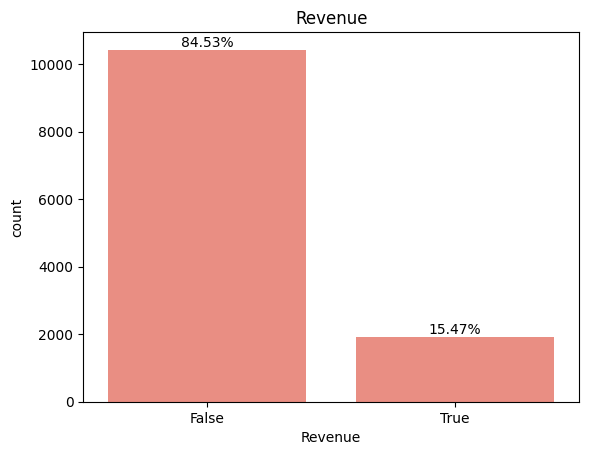

In [115]:
ax = sns.countplot(data=df, x='Revenue')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/len(df)*100:.2f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')
plt.title('Revenue')

print("""
Tenemos muchos mas datos de Revenue = False que de Revenue = True, por lo que el modelo puede tener un sesgo hacia la clase mayoritaria.""")

### Weekend


Podemos observar que si bien hay muchos mas datos de dias de semana (lo cual es logico ya que hay mas dias de semana que fin de semana),
cuando comparamos los datos del Revenue por si es dia de semana o no, no hay diferencia significativa en la cantidad de compras que se realizan.


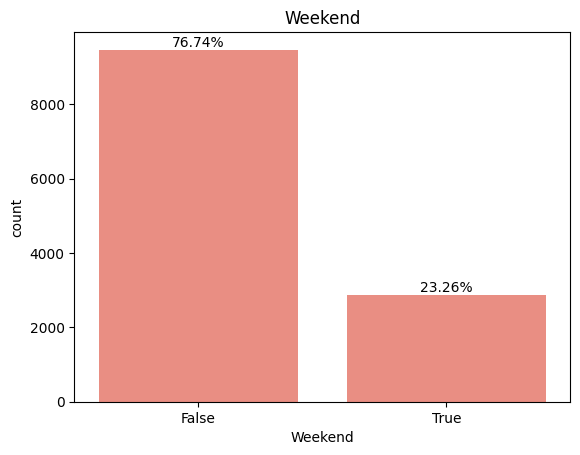

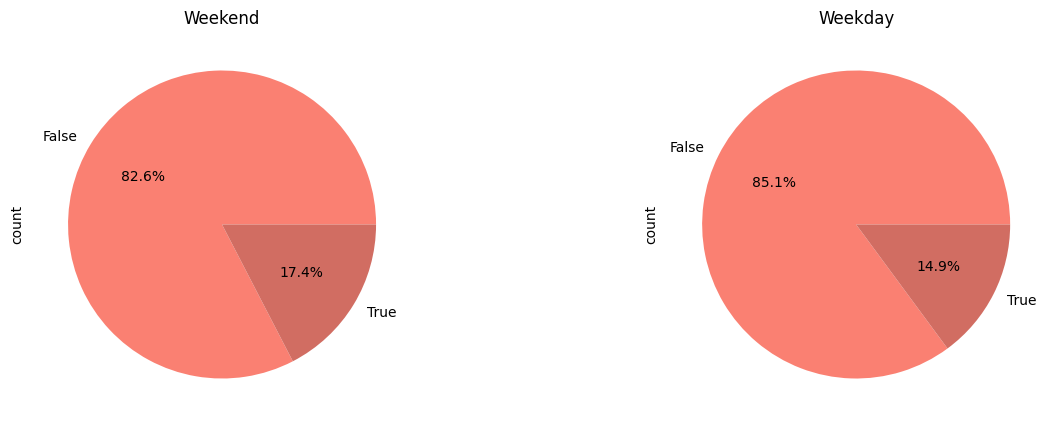

In [116]:
ax = sns.countplot(data=df, x='Weekend')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/len(df)*100:.2f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')
plt.title('Weekend')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

df[df['Weekend'] == True]['Revenue'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax1)
df[df['Weekend'] == False]['Revenue'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax2)

ax1.set_title('Weekend')
ax2.set_title('Weekday')

print("""
Podemos observar que si bien hay muchos mas datos de dias de semana (lo cual es logico ya que hay mas dias de semana que fin de semana),
cuando comparamos los datos del Revenue por si es dia de semana o no, no hay diferencia significativa en la cantidad de compras que se realizan.""")

plt.show()



### ProductRelated y ProductRelated Duration


Podemos observar que ambos tienen una distriubucion similar e inclinada hacia la izquierda,
lo que nos indica que la cantidad de paginas visitadas en la seccion de productos relacionados no influye en si se realiza una compra o no.


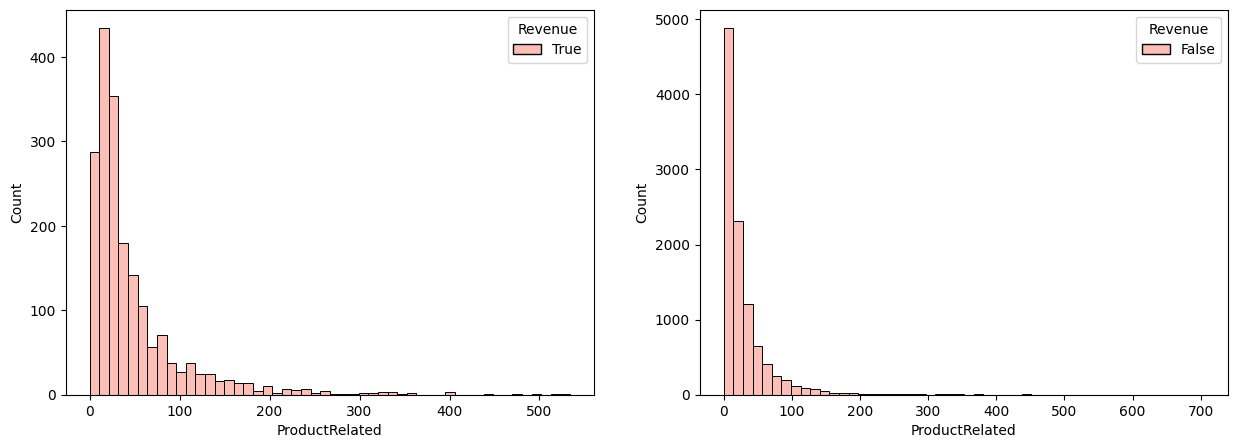

In [117]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=df[df['Revenue']==True], x='ProductRelated', hue='Revenue', ax=ax1, bins=50)
sns.histplot(data=df[df['Revenue']==False], x='ProductRelated', hue='Revenue', ax=ax2, bins=50)

print("""
Podemos observar que ambos tienen una distriubucion similar e inclinada hacia la izquierda,
lo que nos indica que la cantidad de paginas visitadas en la seccion de productos relacionados no influye en si se realiza una compra o no.""")
plt.show()



Podemos obervar que cuando no hay revenue, ña dostrobucion de la variable ProductRelated_Duration esta mucho mas centrada en 0,
Tambien podemos observar que cuando hay revenue, la distribucion de la variable ProductRelated_Duration esta mas dispersa y tiene una cola mas larga, lo que nos indica que la variable influye en si se realiza una compra o no.
 Cuando hacemos el boxplot podemos obervsar que en amobs casos hay numeros que estan muy alejados siendoe stos outliers, esto lo podiamos ver representado en la cola larga de la distribucion de la variable.


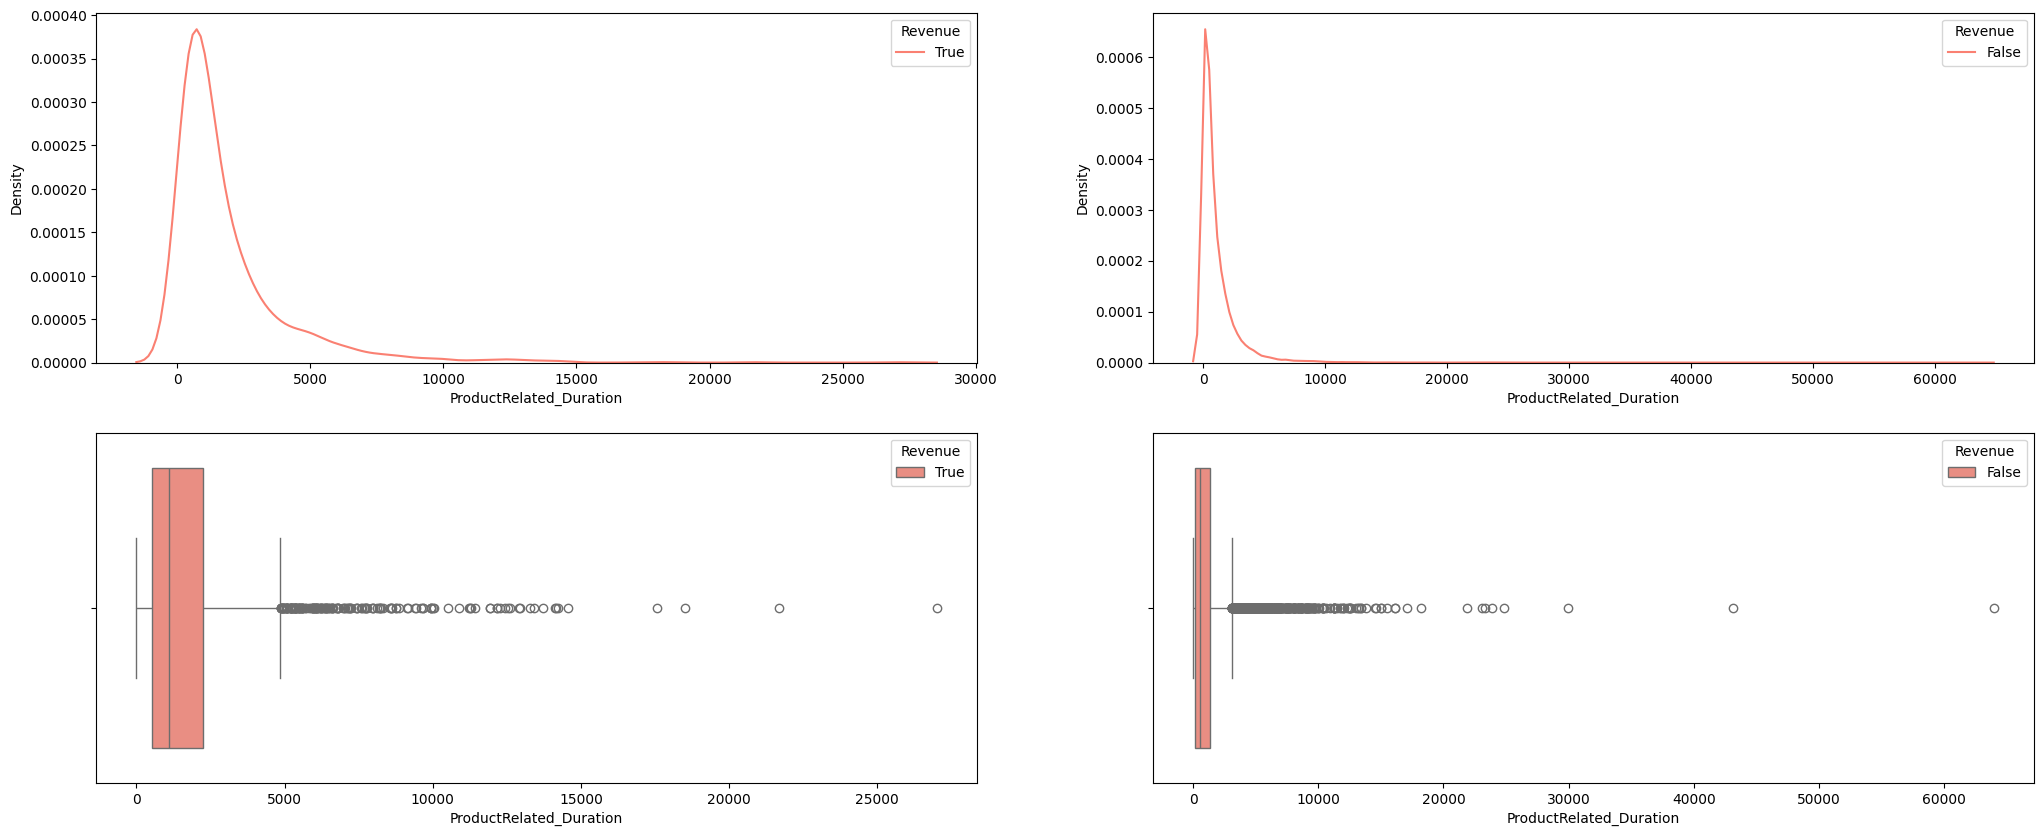

In [118]:
fig, axes = plt.subplots(2, 2, figsize=(25, 10))

sns.kdeplot(data=df[df['Revenue']==True], x='ProductRelated_Duration', hue='Revenue', ax=axes[0,0])
sns.kdeplot(data=df[df['Revenue']==False], x='ProductRelated_Duration', hue='Revenue', ax=axes[0,1])

print("""Podemos obervar que cuando no hay revenue, ña dostrobucion de la variable ProductRelated_Duration esta mucho mas centrada en 0,""")
print("""Tambien podemos observar que cuando hay revenue, la distribucion de la variable ProductRelated_Duration esta mas dispersa y tiene una cola mas larga, lo que nos indica que la variable influye en si se realiza una compra o no.""")
print(""" Cuando hacemos el boxplot podemos obervsar que en amobs casos hay numeros que estan muy alejados siendoe stos outliers, esto lo podiamos ver representado en la cola larga de la distribucion de la variable.""")


sns.boxplot(data=df[df['Revenue']==True], x='ProductRelated_Duration', hue='Revenue', ax=axes[1,0])
sns.boxplot(data=df[df['Revenue']==False], x='ProductRelated_Duration', hue='Revenue', ax=axes[1,1])


plt.show()


### Visitor Type

In [119]:
df.VisitorType.value_counts() #este esta interesante para analizar

VisitorType
Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: count, dtype: int64

Podemos obervar que entre falsos y verdaderos siguen el mismo orden de cantidades en cuanto al tipo de visitante y no cambian tanto el porcenaje que ocupan del total para cada categoria
por lo que no parece ser una variable que influya en si se realiza una compra o no.


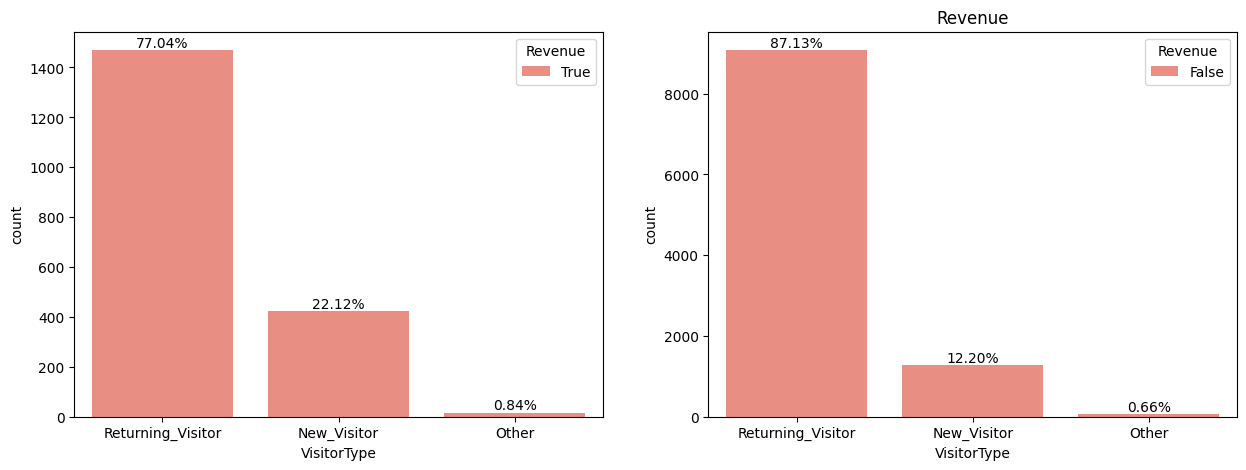

In [120]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(data=df[df['Revenue']==True], x='VisitorType', hue='Revenue', ax=ax1)
sns.countplot(data=df[df['Revenue']==False], x='VisitorType', hue='Revenue', ax=ax2)

# Calculate the percentage of revenue for each category
total_true = len(df[df['Revenue']==True])
total_false = len(df[df['Revenue']==False])

for p in ax1.patches:
    height = p.get_height()
    if height != 0:
        ax1.annotate(f'{height/total_true*100:.2f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')
plt.title('Revenue')

for p in ax2.patches:
    height = p.get_height()
    if height != 0:
        ax2.annotate(f'{height/total_false*100:.2f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')


print("""Podemos obervar que entre falsos y verdaderos siguen el mismo orden de cantidades en cuanto al tipo de visitante y no cambian tanto el porcenaje que ocupan del total para cada categoria
por lo que no parece ser una variable que influya en si se realiza una compra o no.""")


plt.show()





### Month

In [121]:
df_revenue = df[df['Revenue'] == True]
df_not_revenue = df[df['Revenue'] == False]


Podemos observar que la distribución de los meses es muy similar en ambos casos, siendo los meses de mayo y noviembre en ambos casos. Los unicos que van cambiando de lugar son los primeros 4
Para el resto se mantiene igual. Esto podria significar que el mes no es un factor determinante para determinar si hay Revenue o no



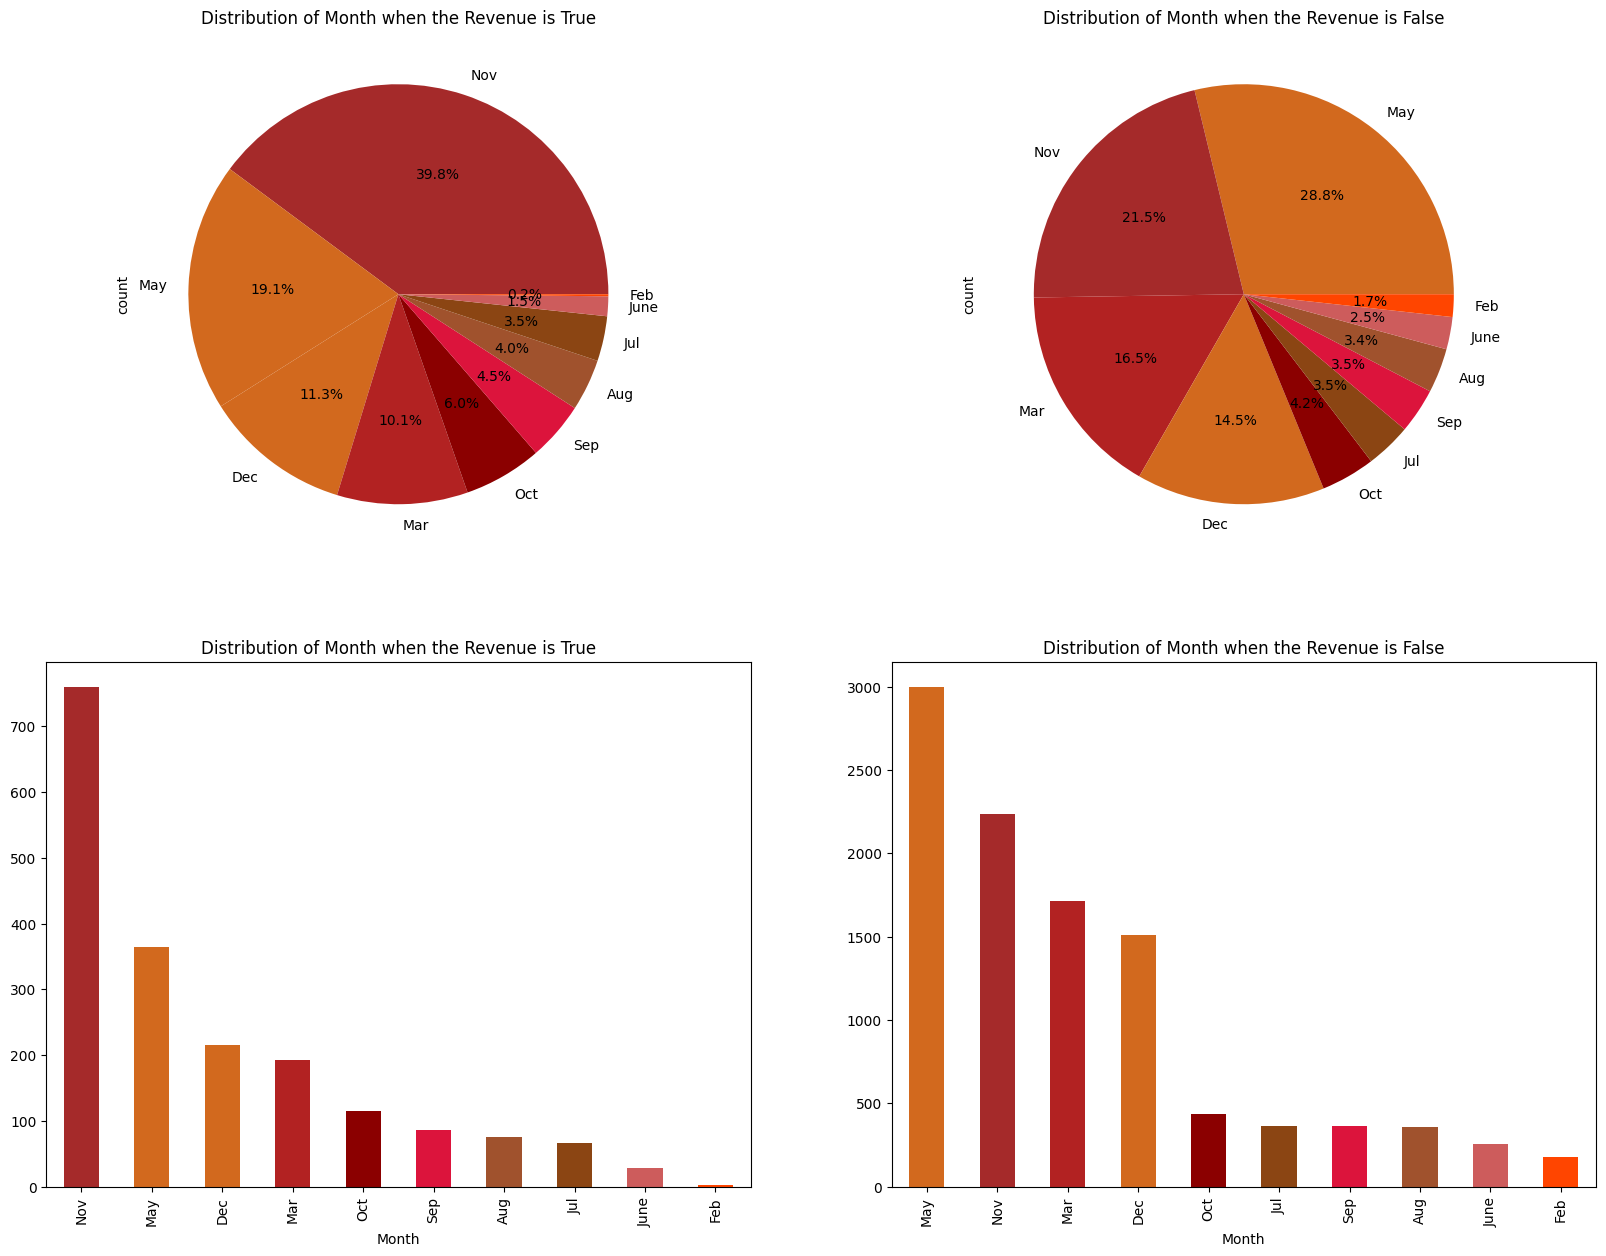

In [122]:
# Define a consistent color map for each month
month_colors = {
    'Jan': '#8B0000',
    'Feb': '#FF4500',
    'Mar': '#B22222',
    'Apr': '#A52A2A',
    'May': '#D2691E',  
    'June': '#CD5C5C',
    'Jul': '#8B4513',
    'Aug': '#A0522D',
    'Sep': '#DC143C',
    'Oct': '#8B0000',
    'Nov': '#A52A2A',
    'Dec': '#D2691E' 
}



# Get the month counts for both dataframes
revenue_month_counts = df_revenue['Month'].value_counts()
not_revenue_month_counts = df_not_revenue['Month'].value_counts()

# Create a color list for each plot based on the month counts index
revenue_colors = [month_colors[month] for month in revenue_month_counts.index]
not_revenue_colors = [month_colors[month] for month in not_revenue_month_counts.index]

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# Plot the pie charts with the specified colors
revenue_month_counts.plot.pie(autopct='%1.1f%%', ax=axes[0,0], colors=revenue_colors)
not_revenue_month_counts.plot.pie(autopct='%1.1f%%', ax=axes[0,1], colors=not_revenue_colors)

revenue_month_counts.plot(kind='bar', color=revenue_colors, ax=axes[1,0])
not_revenue_month_counts.plot(kind='bar', color=not_revenue_colors, ax=axes[1,1])

axes[0,0].set_title('Distribution of Month when the Revenue is True')
axes[0,1].set_title('Distribution of Month when the Revenue is False')

axes[1,0].set_title('Distribution of Month when the Revenue is True')
axes[1,1].set_title('Distribution of Month when the Revenue is False')


print("""
Podemos observar que la distribución de los meses es muy similar en ambos casos, siendo los meses de mayo y noviembre en ambos casos. Los unicos que van cambiando de lugar son los primeros 4
Para el resto se mantiene igual. Esto podria significar que el mes no es un factor determinante para determinar si hay Revenue o no
""")

plt.show()



## HeatMap para ver las correlaciones entre las variables

In [123]:
#Esto lo defino aca con anticipacion porque será el metodo que utilizare para encodear las variables categoricas, capturando asi las relaciones sobre la frecuencia relativa
#de dichas categorias en la columna en su conjunto

def frequency_encoding(data, categorical_columns=categorical_columns):
    data_copy = data.copy()
    
    for column in categorical_columns:
        frequency_map = data_copy[column].value_counts(normalize=True)
        data_copy[column] = data_copy[column].map(frequency_map)
    
    return data_copy


In [124]:
df_correlations = frequency_encoding(df).corr()


Podemos observar que la variable mas correlacionada con Revenue es PageValues, seguido por ExitRates y ProductRelated_Duration.
Tambien podemos ver variables altamente correlacionadas entre si que no tienen que ver con el target. Esto puede afectar a la colinealidad a la hora de generar el modelo.
Por lo tanto luego se procederá a testear esto para que sean eliminadas si es necesario.


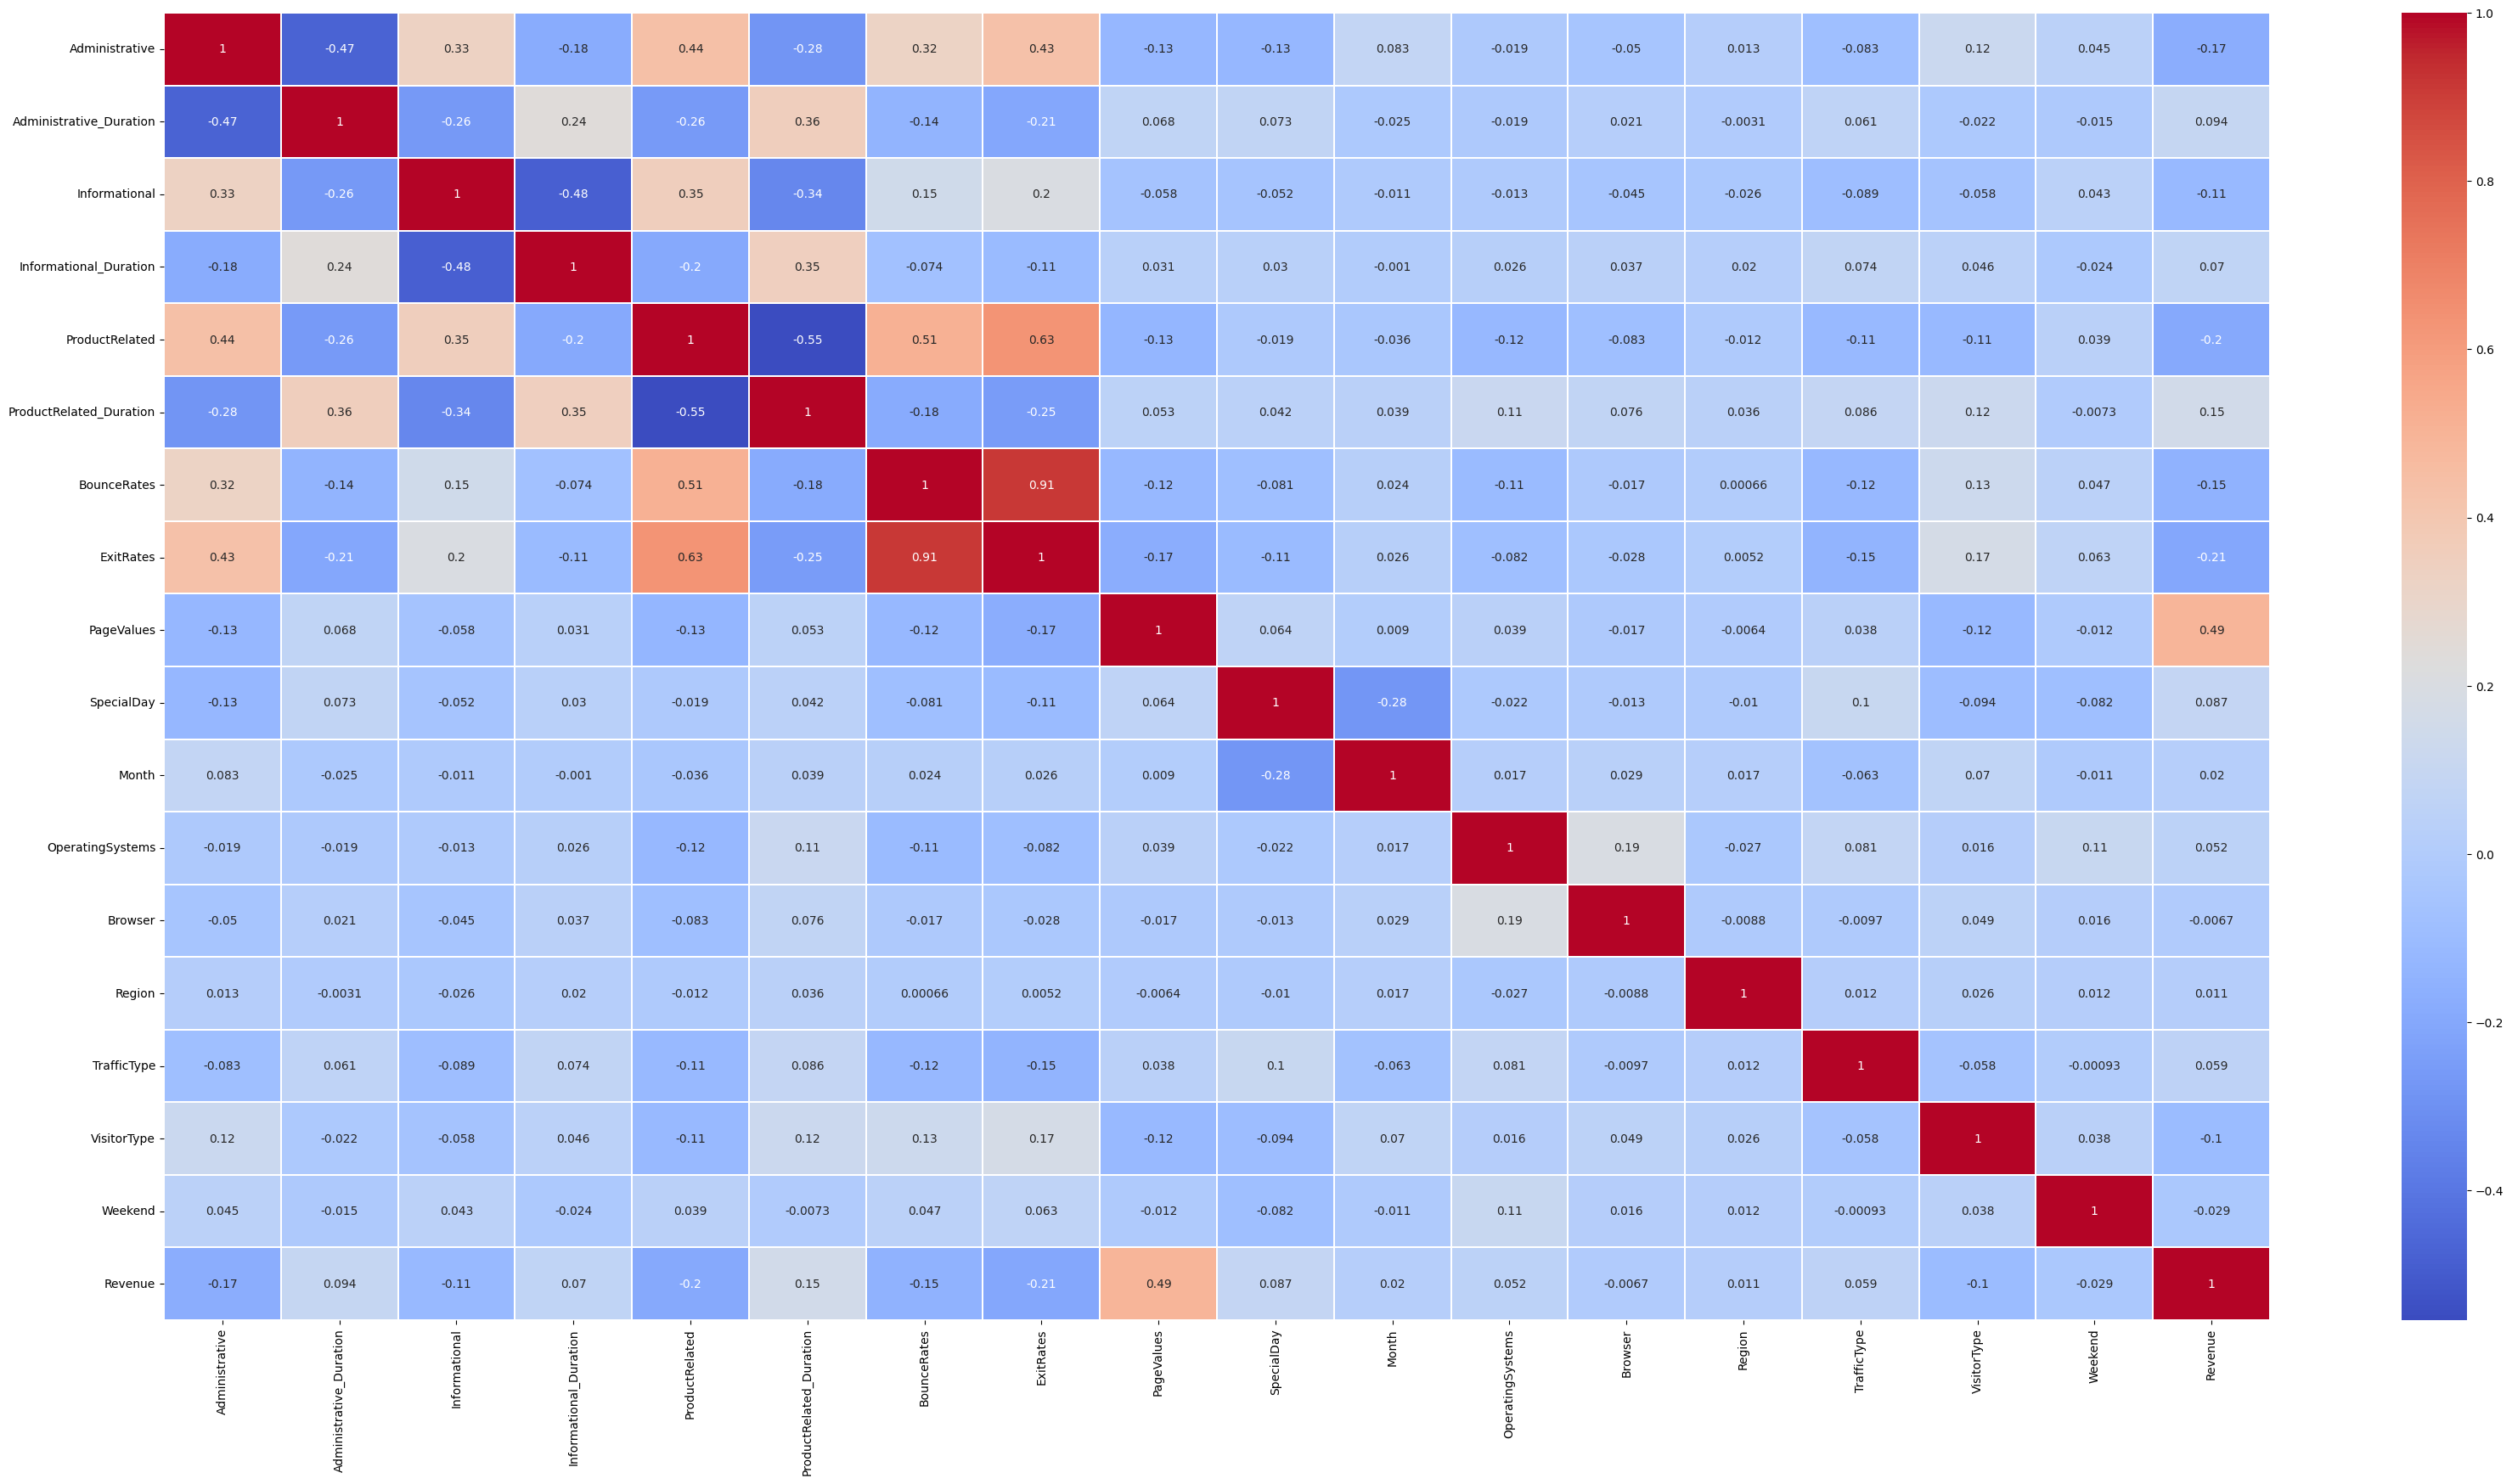

In [125]:
fig, ax = plt.subplots(figsize=(40, 20))

sns.heatmap(df_correlations, cmap='coolwarm', linewidths=0.1, annot=True, ax=ax)

print("""
Podemos observar que la variable mas correlacionada con Revenue es PageValues, seguido por ExitRates y ProductRelated_Duration.
Tambien podemos ver variables altamente correlacionadas entre si que no tienen que ver con el target. Esto puede afectar a la colinealidad a la hora de generar el modelo.
Por lo tanto luego se procederá a testear esto para que sean eliminadas si es necesario.""")

plt.show()

### Page values

------------------Distribución de PageValues------------------


count    12330.000000
mean         5.889258
std         18.568437
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        361.763742
Name: PageValues, dtype: float64

PageValues
0.000000     9600
53.988000       6
42.293068       3
59.988000       2
16.158558       2
             ... 
6.673696        1
6.094324        1
28.253955       1
16.090650       1
12.241717       1
Name: count, Length: 2704, dtype: int64

OBSERVACION : Podemos observar que al igual que variables analizadas anteriormente tenemos colas largas en las distribuciones de esta variables, asi como muchos valores extremos.
y tambien vemos que cuando el targen es negativo, la distribucion de la variable PageValues esta mas centrada en 0, mientras que cuando el target es positivo, la distribucion de la variable PageValues esta mas dispersa.


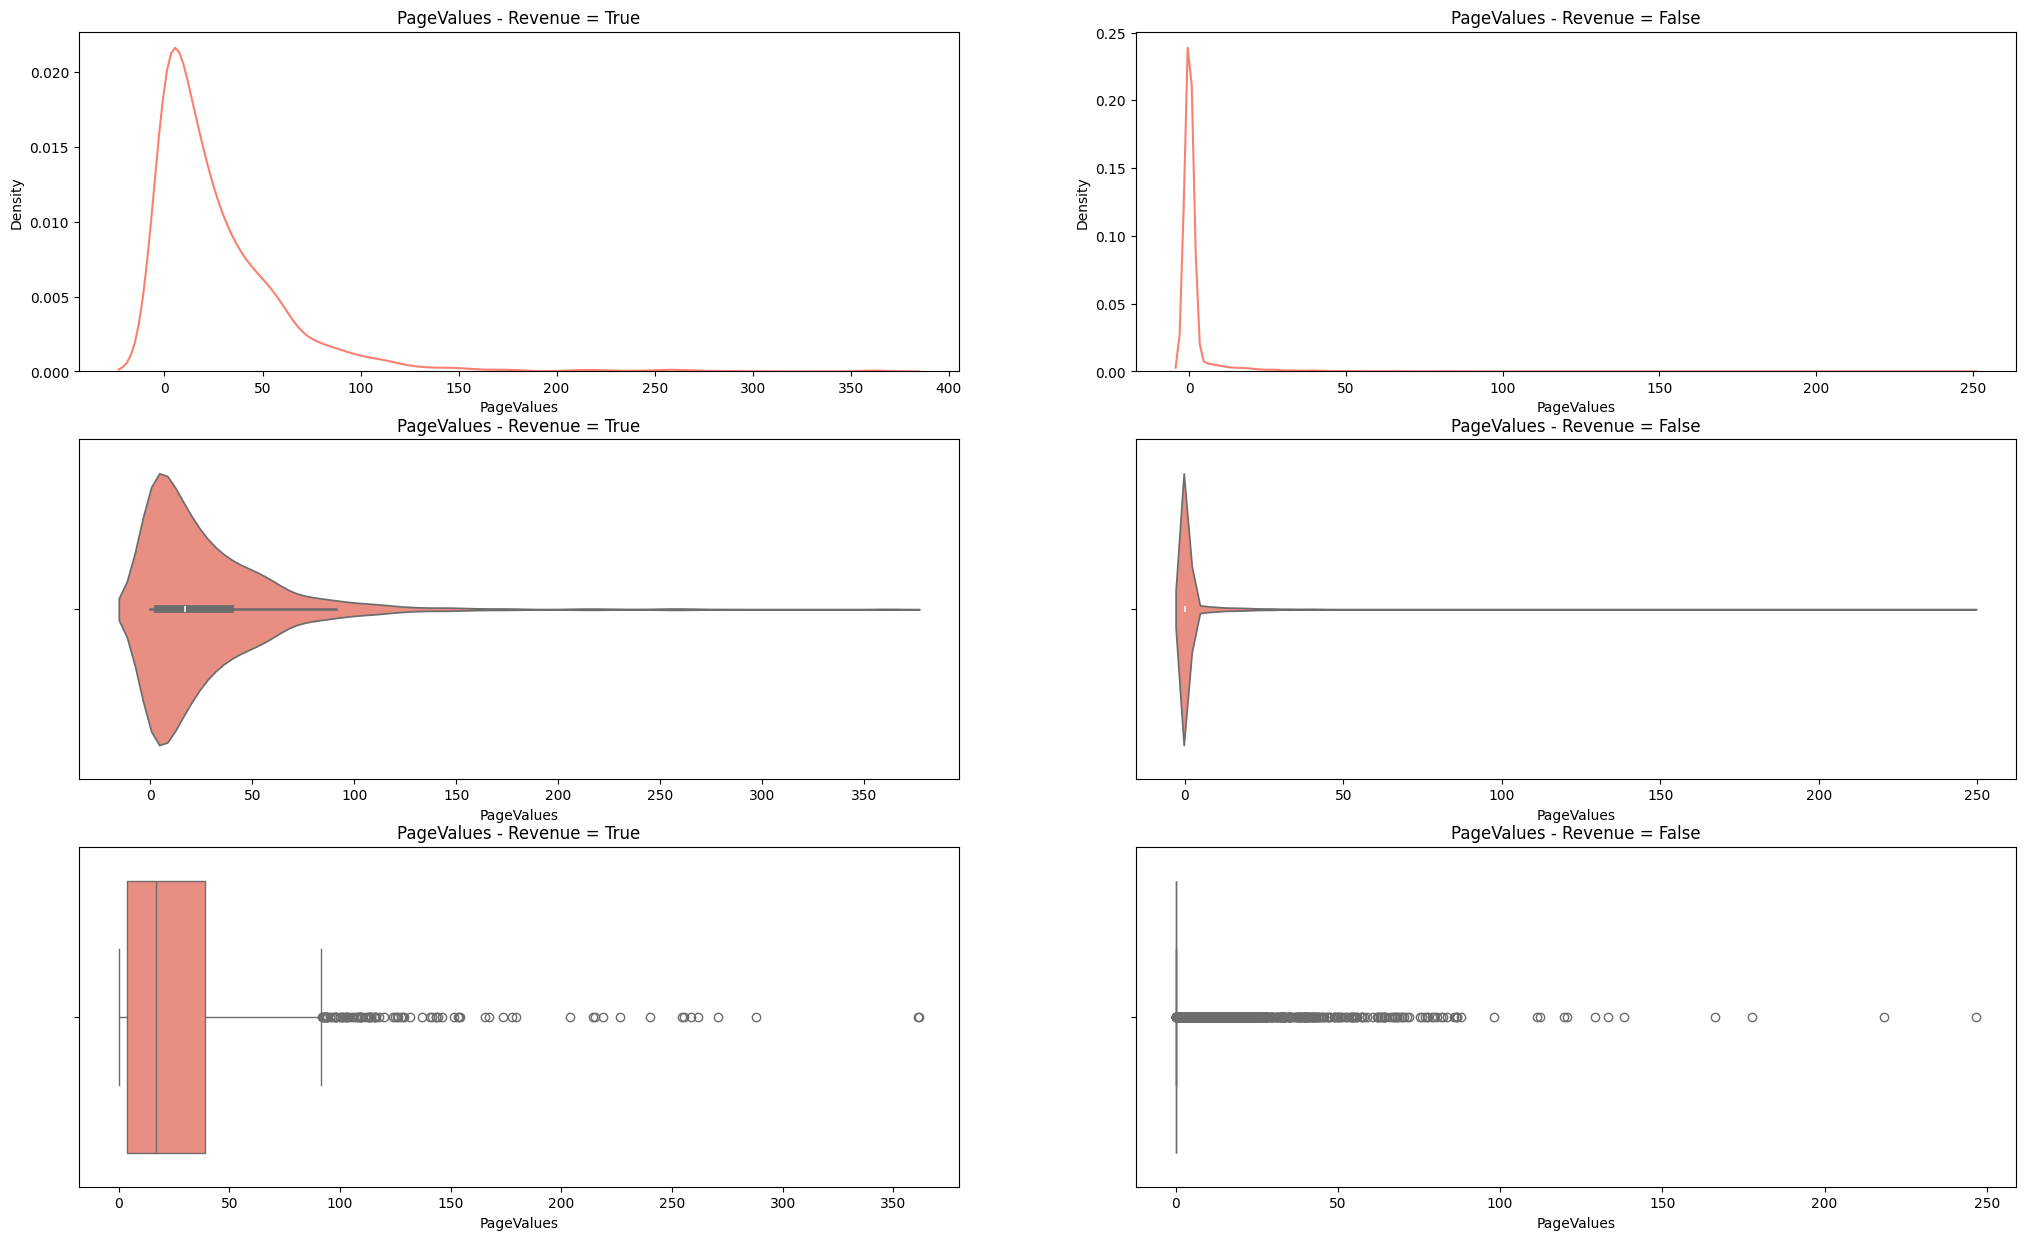

In [126]:
print('------------------Distribución de PageValues------------------')


display(df.PageValues.describe())
display(df.PageValues.value_counts())

fig, axes = plt.subplots(3, 2, figsize=(25, 15))

sns.kdeplot(data=df[df['Revenue']==True], x='PageValues', ax=axes[0,0])
sns.kdeplot(data=df[df['Revenue']==False], x='PageValues', ax=axes[0,1])

sns.violinplot(data=df[df['Revenue']==True], x='PageValues', ax=axes[1,0])
sns.violinplot(data=df[df['Revenue']==False], x='PageValues', ax=axes[1,1])

sns.boxplot(data=df[df['Revenue']==True], x='PageValues', ax=axes[2,0])
sns.boxplot(data=df[df['Revenue']==False], x='PageValues', ax=axes[2,1])


axes[0,0].set_title('PageValues - Revenue = True')
axes[0,1].set_title('PageValues - Revenue = False')

axes[1,0].set_title('PageValues - Revenue = True')
axes[1,1].set_title('PageValues - Revenue = False')

axes[2,0].set_title('PageValues - Revenue = True')
axes[2,1].set_title('PageValues - Revenue = False')


print("""OBSERVACION : Podemos observar que al igual que variables analizadas anteriormente tenemos colas largas en las distribuciones de esta variables, asi como muchos valores extremos.
y tambien vemos que cuando el targen es negativo, la distribucion de la variable PageValues esta mas centrada en 0, mientras que cuando el target es positivo, la distribucion de la variable PageValues esta mas dispersa.""")

## Exit Rates

Podemos ver en estos graficos que con el target positivo la distribucion esta casi toda centrada con una cola ligera, mientras que
cuando tenemos un target negativo, la cola es mas pesada y hay mas ejemplos extremos


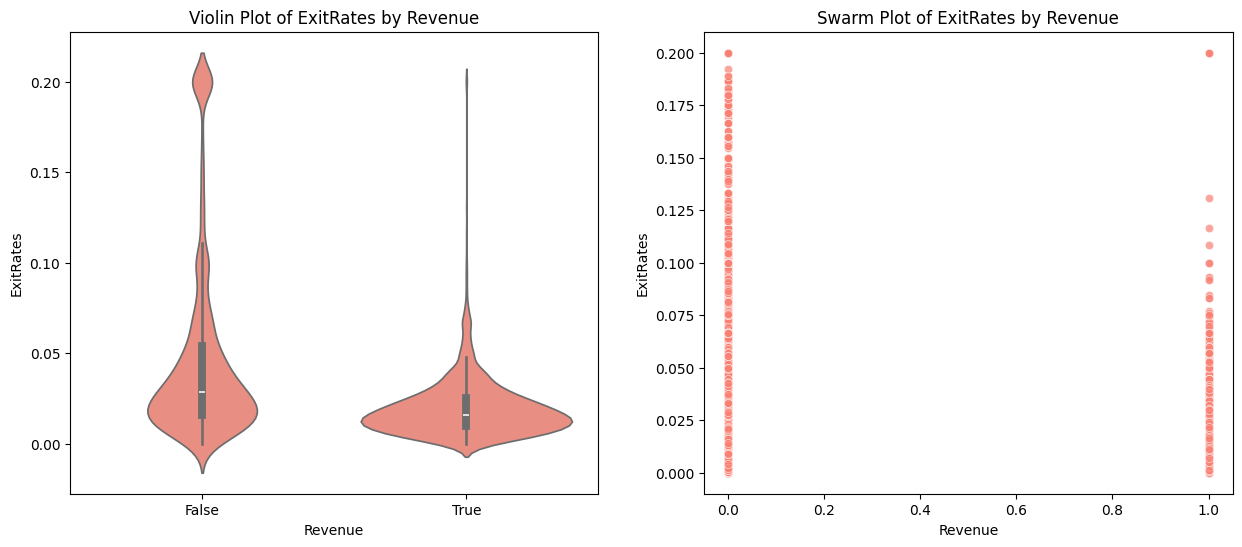

In [127]:

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Violin Plot
sns.violinplot(x='Revenue', y='ExitRates', data=df, ax=axes[0])
# Swarm Plot
sns.scatterplot(x='Revenue', y='ExitRates', data=df, alpha=0.7, ax=axes[1])



axes[0].set_title('Violin Plot of ExitRates by Revenue')
axes[1].set_title('Swarm Plot of ExitRates by Revenue')

print("""Podemos ver en estos graficos que con el target positivo la distribucion esta casi toda centrada con una cola ligera, mientras que
cuando tenemos un target negativo, la cola es mas pesada y hay mas ejemplos extremos""")

plt.show()


Aqui podemos observar un cambio en la distribucion de la variable ExitRates cuando el target es positivo y negativo.
Cuando el target es negativo, vemos que la cola derecha de la distribucion tiene mas valores extremos que cuando el target es positivo.


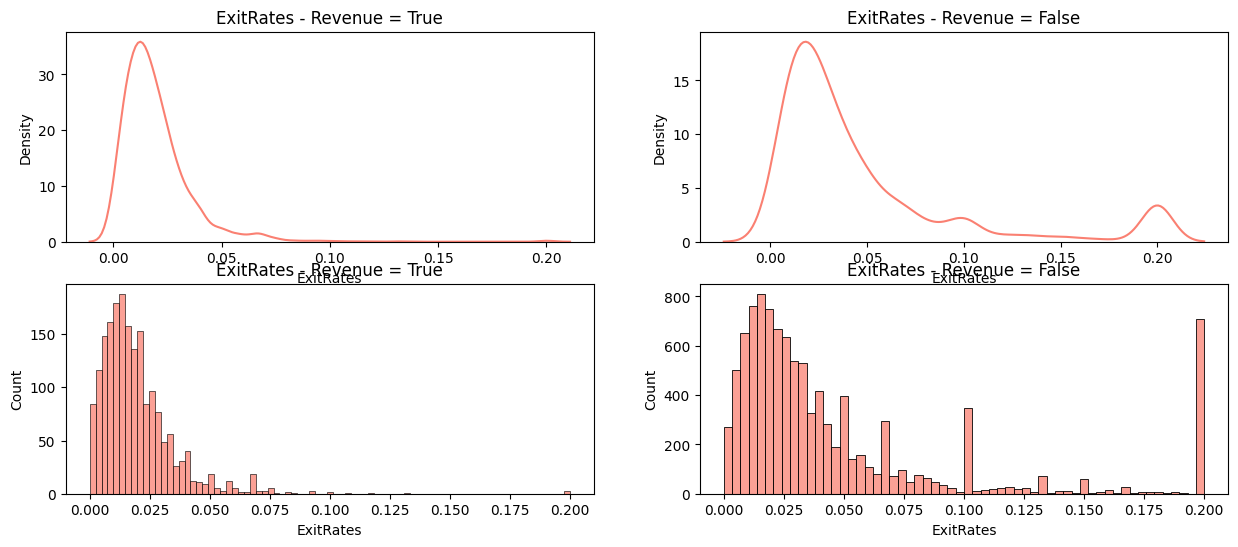

In [128]:
fig, axes = plt.subplots(2, 2, figsize=(15,6))

sns.kdeplot(data=df[df['Revenue']==True], x='ExitRates', ax=axes[0,0])
sns.kdeplot(data=df[df['Revenue']==False], x='ExitRates', ax=axes[0,1])

sns.histplot(data=df[df['Revenue']==True], x='ExitRates', ax=axes[1,0])
sns.histplot(data=df[df['Revenue']==False], x='ExitRates', ax=axes[1,1])

axes[0,0].set_title('ExitRates - Revenue = True')
axes[0,1].set_title('ExitRates - Revenue = False')

axes[1,0].set_title('ExitRates - Revenue = True')
axes[1,1].set_title('ExitRates - Revenue = False')

print("""Aqui podemos observar un cambio en la distribucion de la variable ExitRates cuando el target es positivo y negativo.
Cuando el target es negativo, vemos que la cola derecha de la distribucion tiene mas valores extremos que cuando el target es positivo.""")

plt.show()

### Region

Podemos observar que la region 1 es la que mas compras tiene, seguida por la region 3 y 4. La region 5 es la que menos compras tiene.


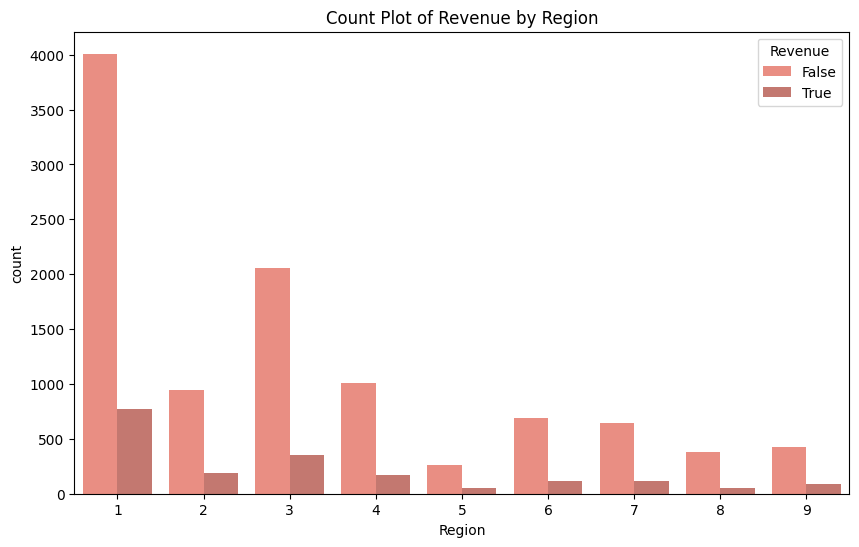

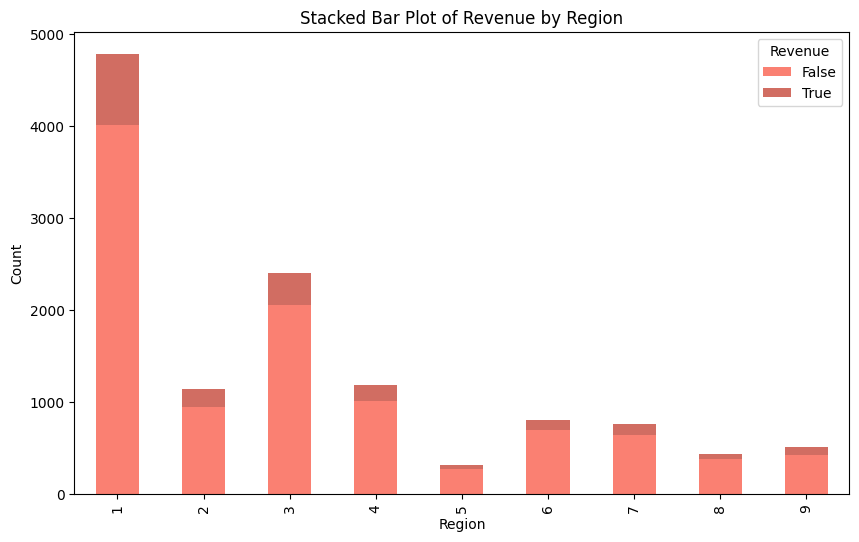

In [129]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Region', hue='Revenue', data=df)
plt.title('Count Plot of Revenue by Region')

print("""Podemos observar que la region 1 es la que mas compras tiene, seguida por la region 3 y 4. La region 5 es la que menos compras tiene.""")
plt.show()

# Stacked Bar Plot
region_revenue_counts = df.groupby(['Region', 'Revenue']).size().unstack().fillna(0)
region_revenue_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Stacked Bar Plot of Revenue by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.legend(title='Revenue')



plt.show()

### Operating System

Podemos observar que tanto si el target es 1 o 0, se mantiene muy similar la distribucion de la variable OperatingSystems
por lo que no parece ser una variable que influya en si se realiza una compra o no.
Vemos un pequeños cambio en que se intecambia el orden de los operating systems 2 y 3 si el target es positivo o negativo. Igualmente, la diferencia es minima en el cambio de orden para el caaso de ser falso.


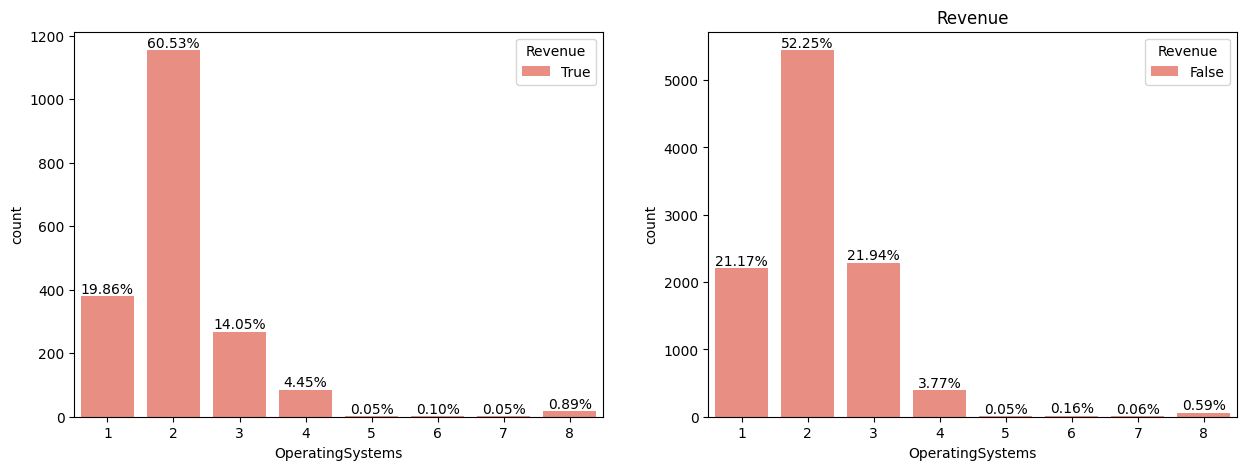

In [130]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(data=df[df['Revenue']==True], x='OperatingSystems', hue='Revenue', ax=ax1)
sns.countplot(data=df[df['Revenue']==False], x='OperatingSystems', hue='Revenue', ax=ax2)

# Calculate the percentage of revenue for each category
total_true = len(df[df['Revenue']==True])
total_false = len(df[df['Revenue']==False])

for p in ax1.patches:
    height = p.get_height()
    if height != 0:
        ax1.annotate(f'{height/total_true*100:.2f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')
plt.title('Revenue')

for p in ax2.patches:
    height = p.get_height()
    if height != 0:
        ax2.annotate(f'{height/total_false*100:.2f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')


print("""Podemos observar que tanto si el target es 1 o 0, se mantiene muy similar la distribucion de la variable OperatingSystems
por lo que no parece ser una variable que influya en si se realiza una compra o no.
Vemos un pequeños cambio en que se intecambia el orden de los operating systems 2 y 3 si el target es positivo o negativo. Igualmente, la diferencia es minima en el cambio de orden para el caaso de ser falso.""")

plt.show()

## Analsis de outliers

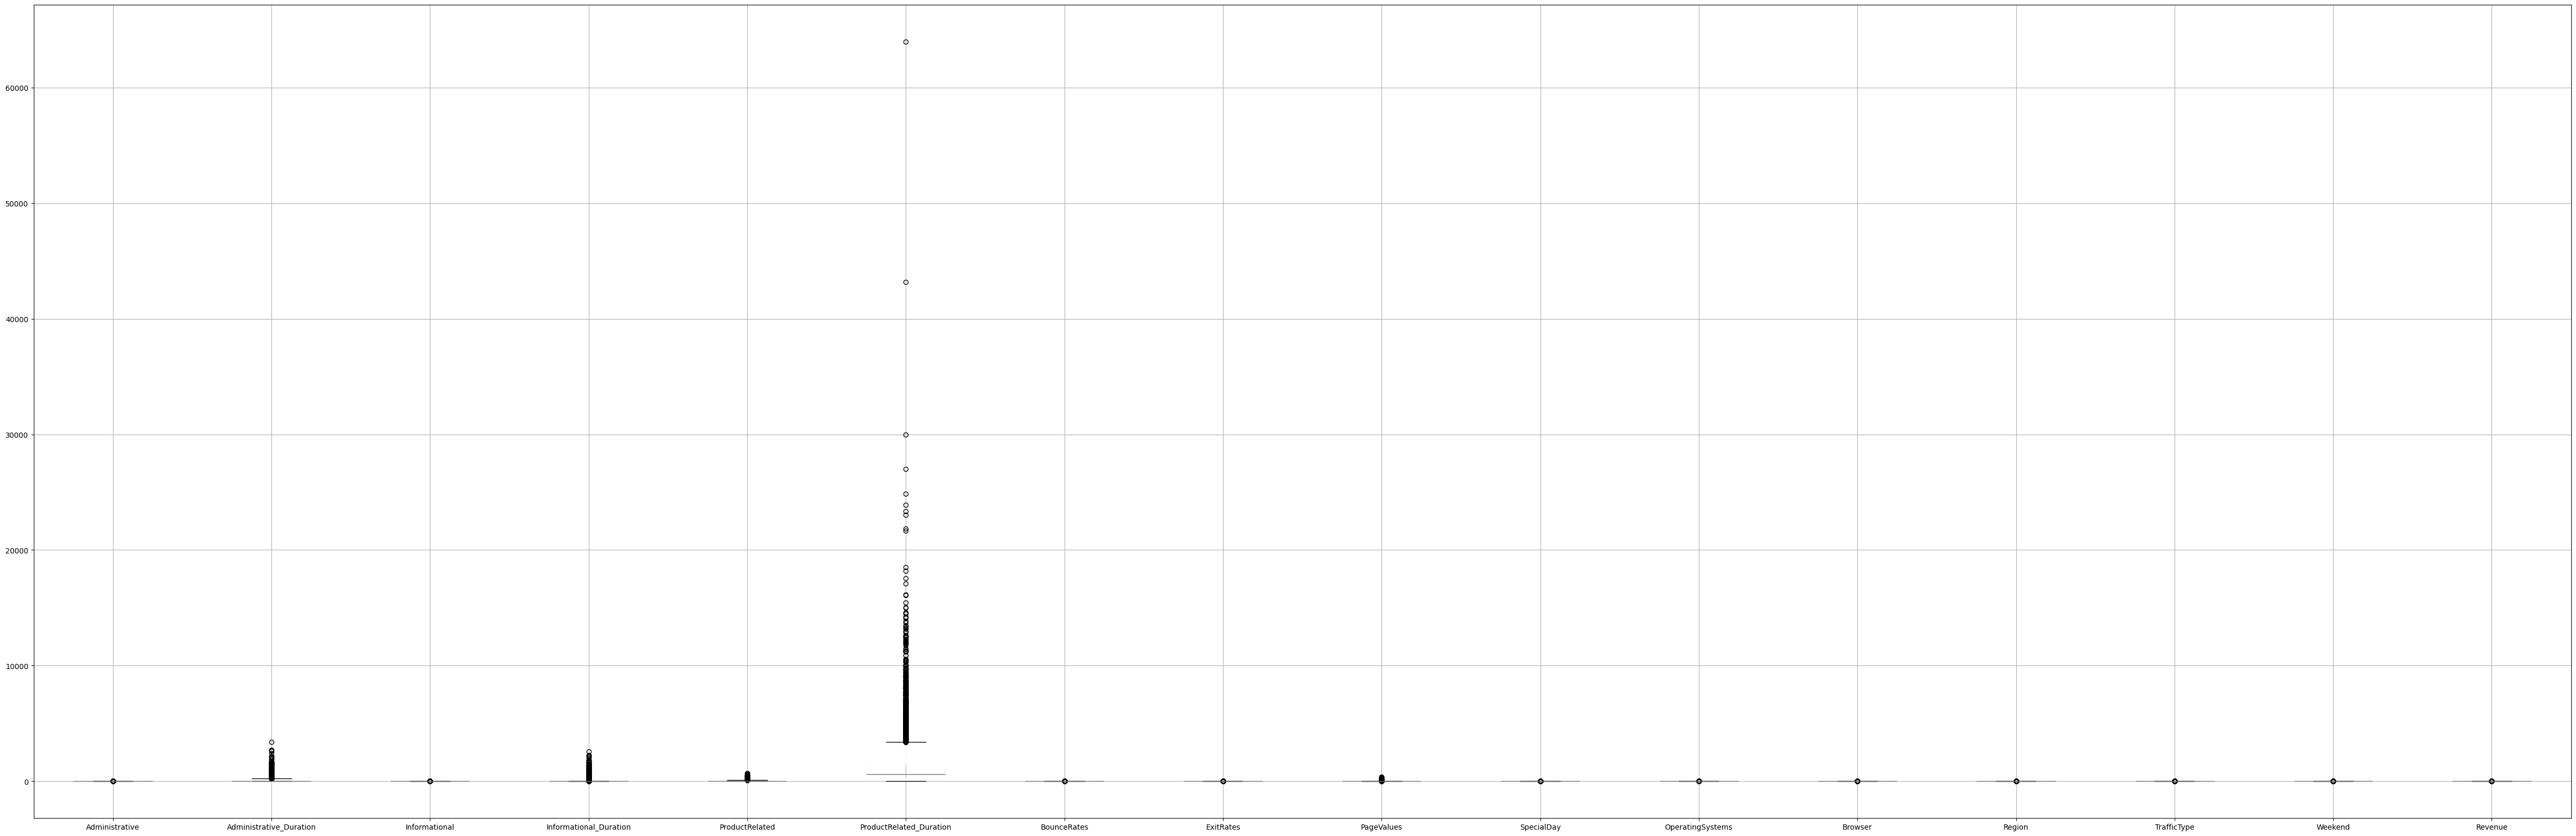

In [131]:
plt.figure(figsize=(62, 20))
df.boxplot();

In [132]:
df_encoded = frequency_encoding(df)

Podemos observar que las columnas que mas outliers tienen son BounceRates y ExitRates, que a su vez estan altamente correlacionadas, asi que cuando hagamos frature selection,
y probablemente eliminemos alguna, se van a ir muchos outliers del total.
Lo que se uso aqui es una regla empirica con el metodo Z, La elección del 3 como umbral proviene de la regla empírica, 
según la cual los datos dentro de 3 veces la desviación estándar respecto a la media representan el 99.7% de los datos de la distribución.
Sabiendo esto, podemos concluir con bastante seguridad que los datos que caen más allá de este umbral son atípicos, pues son distintos al 99.7% de los datos.


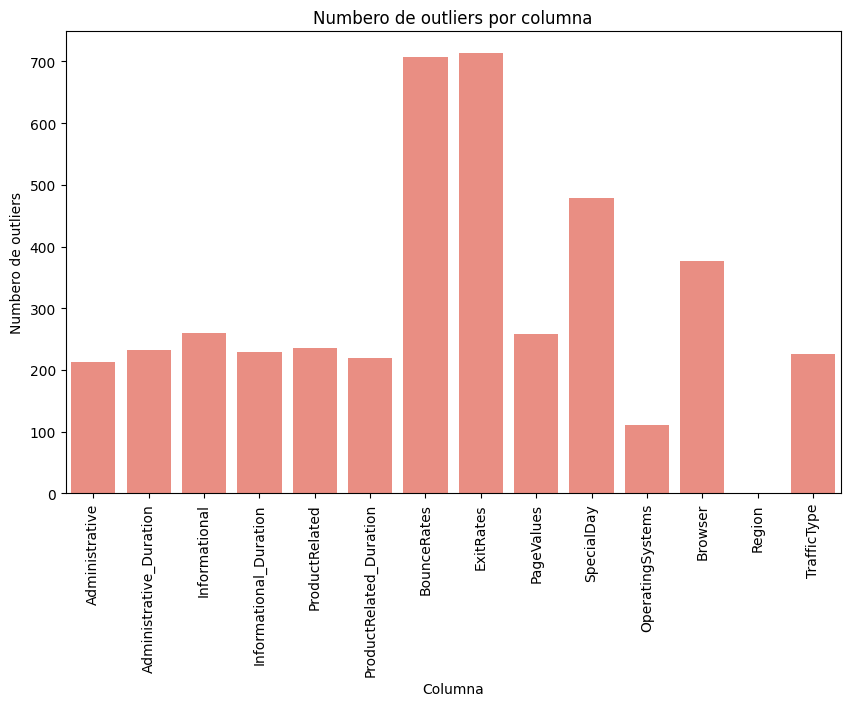

In [133]:

outlier_counts = pd.DataFrame(columns=['Column', 'Num_Outliers'])


out_columns = df.select_dtypes(include=[np.number]).columns


results = []

for column in out_columns:
    
    column_data = df[column].fillna(df[column].mean())
    
    z_scores = zscore(column_data)
    abs_z_scores = np.abs(z_scores)
    outliers = df[abs_z_scores > 3]
    num_outliers = len(outliers)
    
    
    results.append({'Column': column, 'Num_Outliers': num_outliers})


outlier_counts = pd.DataFrame(results)


plt.figure(figsize=(10, 6))
sns.barplot(x='Column', y='Num_Outliers', data=outlier_counts)
plt.xticks(rotation=90)
plt.title('Numbero de outliers por columna')
plt.xlabel('Columna')
plt.ylabel('Numbero de outliers')

print("""Podemos observar que las columnas que mas outliers tienen son BounceRates y ExitRates, que a su vez estan altamente correlacionadas, asi que cuando hagamos frature selection,
y probablemente eliminemos alguna, se van a ir muchos outliers del total.
Lo que se uso aqui es una regla empirica con el metodo Z, La elección del 3 como umbral proviene de la regla empírica, 
según la cual los datos dentro de 3 veces la desviación estándar respecto a la media representan el 99.7% de los datos de la distribución.
Sabiendo esto, podemos concluir con bastante seguridad que los datos que caen más allá de este umbral son atípicos, pues son distintos al 99.7% de los datos.""")
plt.show()


### Informational e InformationalDuration


Podemos observar que ambos tienen una distriubucion similar e inclinada hacia la izquierda,



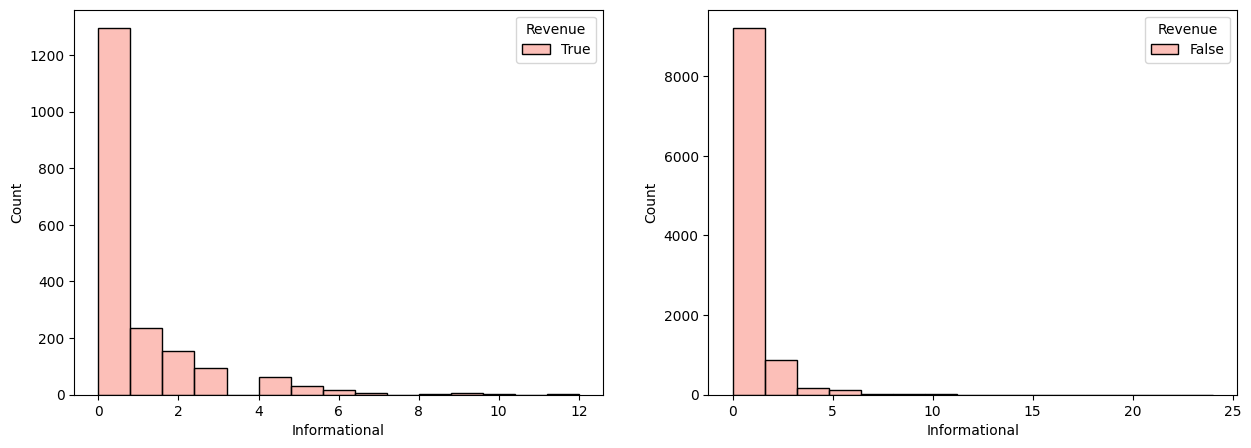

In [134]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=df[df['Revenue']==True], x='Informational', hue='Revenue', ax=ax1, bins=15)
sns.histplot(data=df[df['Revenue']==False], x='Informational', hue='Revenue', ax=ax2, bins=15)

print("""
Podemos observar que ambos tienen una distriubucion similar e inclinada hacia la izquierda,
""")

plt.show()

Podemos obervar que cuando no hay revenue, la distrobucion de la variable Informational_Duration esta mucho mas centrada en 0, 
tambien podemos observar que cuando hay revenue, la distribucion de la variable Informational_Duration tiene un mayor desvioestandar
 Cuando hacemos el boxplot podemos obervsar que en amobs casos hay numeros que estan muy alejados siendoe stos outliers, esto lo podiamos ver representado en la cola larga de la distribucion de la variable.


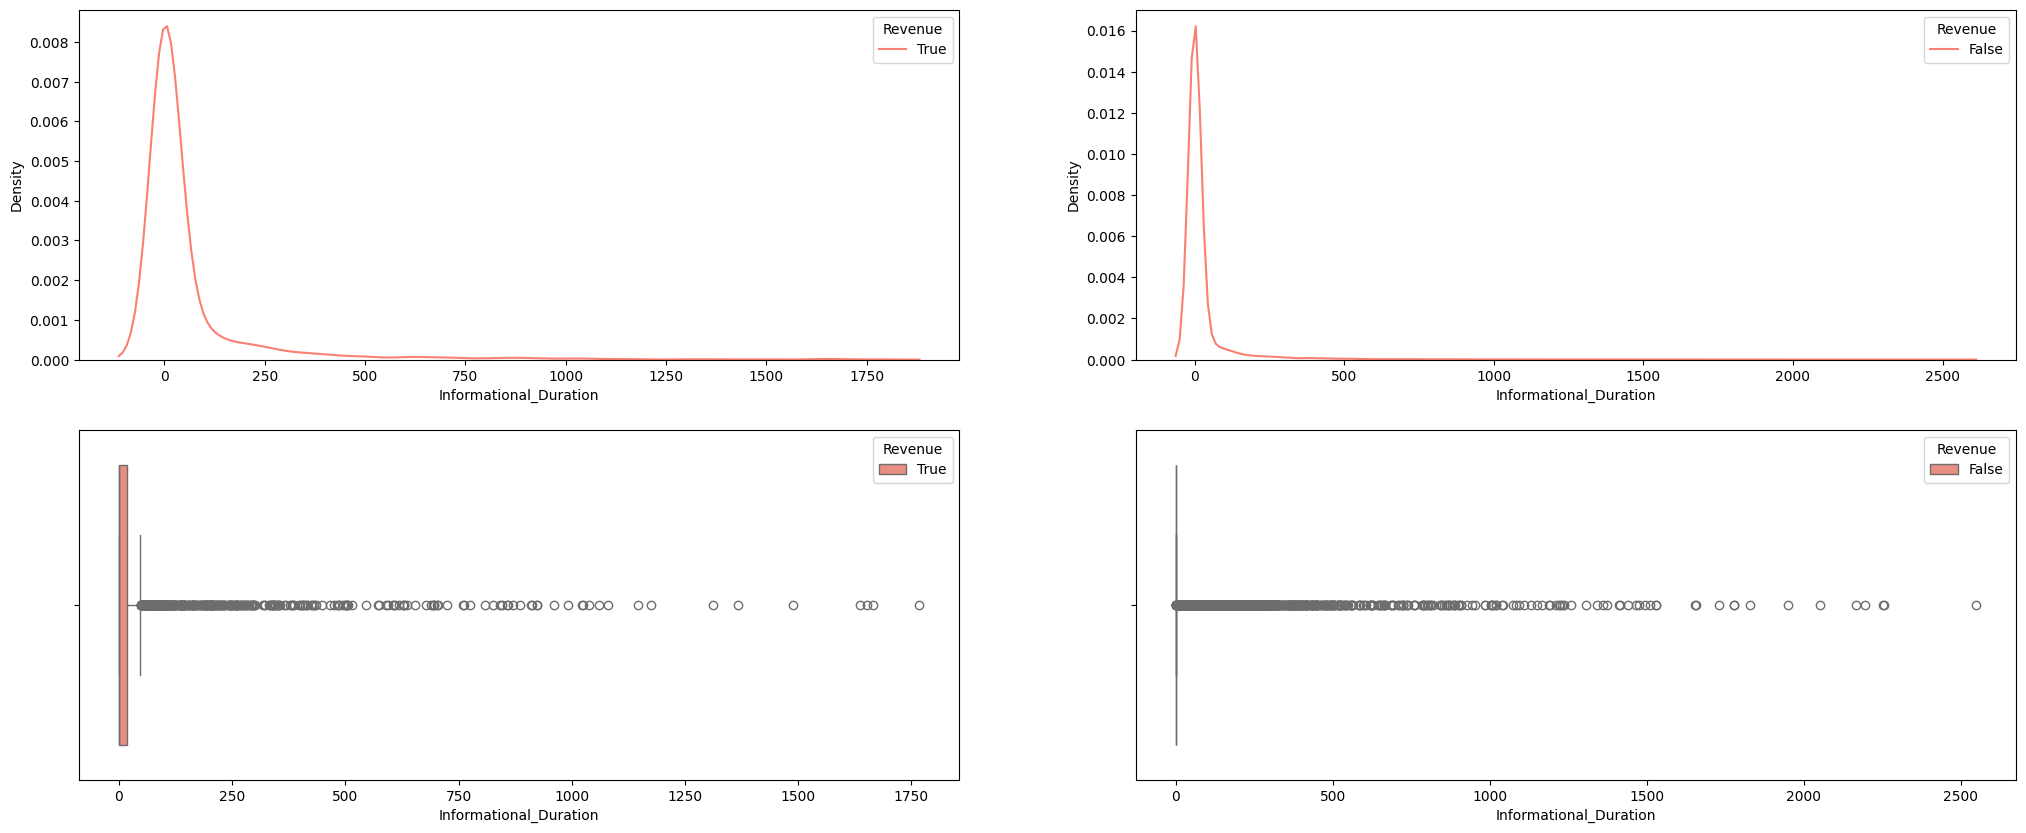

In [135]:
fig, axes = plt.subplots(2, 2, figsize=(25, 10))

sns.kdeplot(data=df[df['Revenue']==True], x='Informational_Duration', hue='Revenue', ax=axes[0,0])
sns.kdeplot(data=df[df['Revenue']==False], x='Informational_Duration', hue='Revenue', ax=axes[0,1])

print("""Podemos obervar que cuando no hay revenue, la distrobucion de la variable Informational_Duration esta mucho mas centrada en 0, 
tambien podemos observar que cuando hay revenue, la distribucion de la variable Informational_Duration tiene un mayor desvioestandar""")
print(""" Cuando hacemos el boxplot podemos obervsar que en amobs casos hay numeros que estan muy alejados siendoe stos outliers, esto lo podiamos ver representado en la cola larga de la distribucion de la variable.""")


sns.boxplot(data=df[df['Revenue']==True], x='Informational_Duration', hue='Revenue', ax=axes[1,0])
sns.boxplot(data=df[df['Revenue']==False], x='Informational_Duration', hue='Revenue', ax=axes[1,1])
plt.show()


## Machine learning

Para esta parte voy a elegir y justificar una metrica de base para elegir el modelo y el algoritmo.
- Primero inicializo un diccionario con diferentes tipos de algoritmos para clasificación:
---
- XGBoost Classifier
- Logistic Regression
- MLP Classifier
- Random Forest Classifier
---
- Las metricas que seran tenidas en cuenta son:
---
- F1 Score: Media armonica entre Precision (Cuantos de los que dije que eran 1, efectivamente eran 1) y Recall (de todos los que eran 1, a cuantos efectivamente detecté).
- AUC-ROC: Metrica robusta para problemas de clasificacion que combina el AUC (area under the curve), que proporciona un unico valor que resume el desempeño del modelo en todos los umbrales posibles, siendo 0.5 un modelo sin capacidad de distinguir entre clases y 1 una clasificacion perfecta; y esta se combina con ROC (Receiver Operatinv Characteristic) que es una grafica que muestra el desempeño de un modelo en diferentes umbrales de decision, compuesto en el eje "x" de la tasa de falsos positivos, y en el eje "y" de la tasa de verdaderos positivos. En resumen: ROC es una curva de probabilidad y AUC representa el grado o medida de separabilidad. Indica cuánto es capaz el modelo de distinguir entre clases.
---
Nota: Podria elegir otras matricas como accuracy, Precision, Recall, etc.
Pero para el problema actual que consiste en predecir si hay una venta dadas la visita del consumidor al sitio online, deberia ver cual seria el caso de uso del modelo.
Dependiendo de para que se usaria usaria una metrica u otra. Por ejemplo: en caso de que se hiciera para utilizarlo en una campaña publicitaria, me interesaria maximizar la precision (de las veces que dije que es un 1, cuantas era realmente un 1) en vez del recall (de todos los 1, a cuantos le acerte). Ya que priorizando esta minimizaria el costo de la campaña.

Primero va el preprocesado

In [26]:
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, learning_curve, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, auc, roc_curve, make_scorer, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from sklearn.decomposition import PCA
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

In [85]:
#Vuelvo a definir frequency_encoding por si se quiere correr solo esta parte del challenge
np.random.seed(22)

def frequency_encoding(data, categorical_columns=categorical_columns):
    data_copy = data.copy()
    
    for column in categorical_columns:
        frequency_map = data_copy[column].value_counts(normalize=True)
        data_copy[column] = data_copy[column].map(frequency_map)
    
    return data_copy

df = frequency_encoding(data=df, categorical_columns=categorical_columns)


le = LabelEncoder()


df['Revenue'] = le.fit_transform(df['Revenue'])

test_multicolinealidad = df.corr()
if np.linalg.det(test_multicolinealidad) < 0.2:
    print('Hay colinalidad, el resultado es:', np.linalg.det(test_multicolinealidad))
else:
    print('Todo bien')



Hay colinalidad, el resultado es: 0.008820287543952886


In [86]:
#Como vimos en el EDA que habia variables muy correlacionadas, vamos a dropear una de ellas y quedarnos con la otra. Asi podemos lidiar con la colinealidad

df.drop(['ProductRelated_Duration','BounceRates'], axis=1, inplace=True)


In [87]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Revenue', axis=1), df['Revenue'], test_size=0.2)

Una vez que splitee los datos, toca el escalado de features y encoding. Siempre debe ser despues del split para evitar data leakage

In [88]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

Ahora estamos listos para Entrenar los modelos. Se va a optar por un StratifiedKfolds para el grid search y asi mantener la proprocion de 0 y 1 en los 5 folds que vamos a usar

In [89]:
roc_aucs = []
f1s = []
model_instances = []

models = {'Logistic Regression': 0,
          'Random Forest': 0,
          'MLP' : 0, 
          'xgb': 0}


1) Logistic Regression 

Best score of Logistic Regression: 0.8875507736329011
-------------------------------
F1 Score on Train Set: 0.6250675310642896
F1 Score on Test Set: 0.6338185890257558
-------------------------------
ROC-AUC Score on train: 0.8177942766086653
ROC-AUC Score on Test: 0.8164750089692026
------------------------------
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      2085
           1       0.55      0.74      0.63       381

    accuracy                           0.87      2466
   macro avg       0.75      0.82      0.78      2466
weighted avg       0.89      0.87      0.87      2466



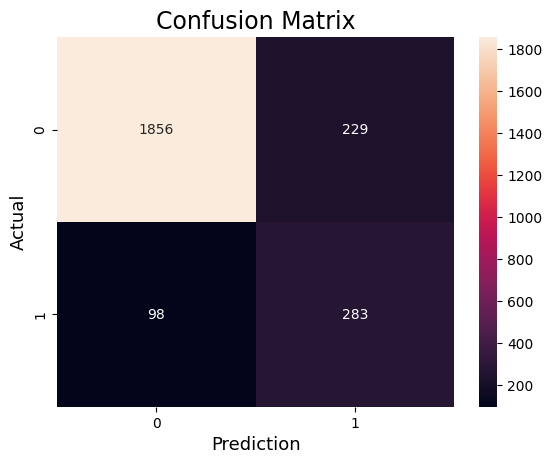

In [90]:
model = LogisticRegression()

st_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)

log_reg_grid_search = GridSearchCV(model, param_grid = {'class_weight' : ['balanced', None]}, cv = st_kfold, scoring = 'roc_auc', n_jobs = -1)
log_reg_grid_search.fit(X_train_scaled, y_train)

best_log = log_reg_grid_search.best_estimator_
model_instances.append(best_log)

y_pred_train = best_log.predict(X_train_scaled)
f1_train = f1_score(y_train, y_pred_train)

print('Best score of Logistic Regression:', log_reg_grid_search.best_score_)

print('-------------------------------')

#F1
print('F1 Score on Train Set:', f1_train)

y_pred = best_log.predict(X_test_scaled)
f1 = f1_score(y_test, y_pred)
print('F1 Score on Test Set:', f1)

print('-------------------------------')
#ROC-AUC
roc_auc_train = roc_auc_score(y_train, y_pred_train)
roc_auc = roc_auc_score(y_test, y_pred)

print('ROC-AUC Score on train:', roc_auc_train)
print('ROC-AUC Score on Test:', roc_auc)

models['Logistic Regression'] = roc_auc


roc_aucs.append(roc_auc_score(y_test, y_pred))
f1s.append(f1_score(y_test, y_pred))

print('------------------------------')

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred),
              annot=True,
              fmt='g',
              xticklabels=['0', '1'],
              yticklabels=['0', '1'])
plt.ylabel('Actual', fontsize=13)
plt.xlabel('Prediction', fontsize=13)
plt.title('Confusion Matrix', fontsize=17)
plt.show()

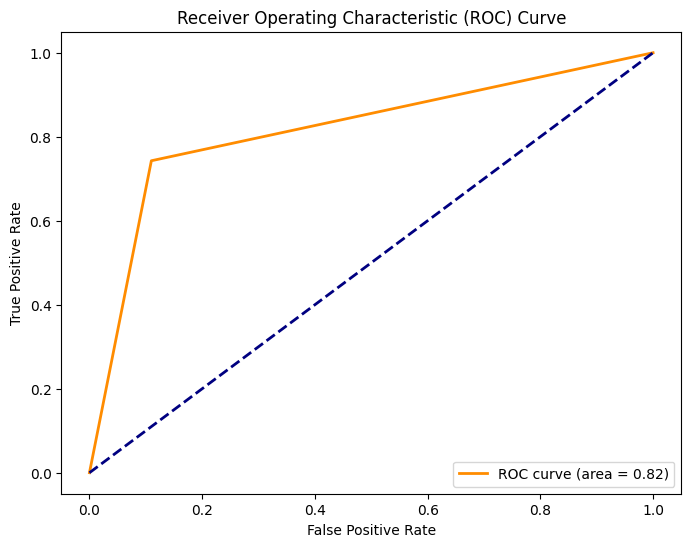

In [91]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

2) Random Forest

Best score of Random Forest: 0.9246818634904009
-------------------------------
F1 Score on Train Set: 0.910056657223796
F1 Score on Test Set: 0.6266866566716641
-------------------------------
ROC-AUC Score on train: 0.9200399761236687
ROC-AUC Score on Test: 0.7558129874053514
------------------------------
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2085
           1       0.73      0.55      0.63       381

    accuracy                           0.90      2466
   macro avg       0.83      0.76      0.78      2466
weighted avg       0.89      0.90      0.89      2466



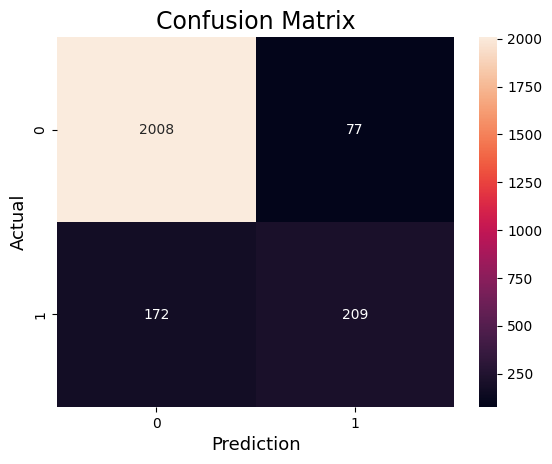

In [92]:
model = RandomForestClassifier()

st_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)

rf_param_grid = {'n_estimators': [80 ,100, 200, 300],
                'max_depth': [5, 10, 15],
                'min_samples_split': [2, 5, 10]}

rf_grid_search = GridSearchCV(model, param_grid = rf_param_grid, cv = st_kfold, scoring = 'roc_auc', n_jobs = -1)
rf_grid_search.fit(X_train_scaled, y_train)

best_rf = rf_grid_search.best_estimator_
model_instances.append(best_rf)

y_pred_train = best_rf.predict(X_train_scaled)
f1_train = f1_score(y_train, y_pred_train)

print('Best score of Random Forest:', rf_grid_search.best_score_)

print('-------------------------------')

#F1
print('F1 Score on Train Set:', f1_train)

y_pred = best_rf.predict(X_test_scaled)
f1 = f1_score(y_test, y_pred)
print('F1 Score on Test Set:', f1)

print('-------------------------------')
#ROC-AUC
roc_auc_train = roc_auc_score(y_train, y_pred_train)
roc_auc = roc_auc_score(y_test, y_pred)

print('ROC-AUC Score on train:', roc_auc_train)
print('ROC-AUC Score on Test:', roc_auc)

models['Random Forest'] = roc_auc


roc_aucs.append(roc_auc_score(y_test, y_pred))
f1s.append(f1_score(y_test, y_pred))

print('------------------------------')

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred),
              annot=True,
              fmt='g',
              xticklabels=['0', '1'],
              yticklabels=['0', '1'])
plt.ylabel('Actual', fontsize=13)
plt.xlabel('Prediction', fontsize=13)
plt.title('Confusion Matrix', fontsize=17)
plt.show()

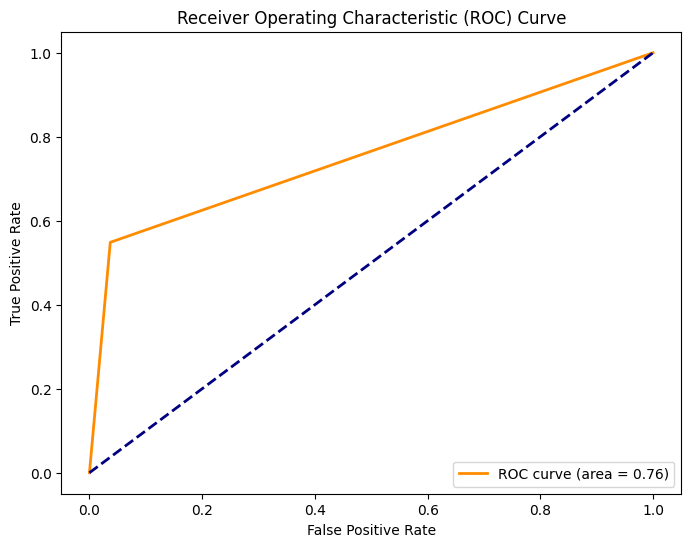

In [93]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

3) MLP Classifier

Best score of MPL: 0.8884789595064252
-------------------------------
F1 Score on Train Set: 0.7546897546897547
F1 Score on Test Set: 0.6151603498542274
-------------------------------
ROC-AUC Score on train: 0.8305668884865512
ROC-AUC Score on Test: 0.754360920712249
------------------------------
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2085
           1       0.69      0.55      0.62       381

    accuracy                           0.89      2466
   macro avg       0.81      0.75      0.78      2466
weighted avg       0.89      0.89      0.89      2466



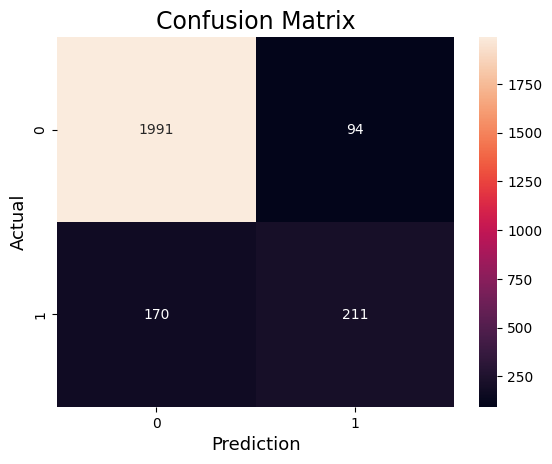

In [94]:
model = MLPClassifier()

mlp_param_grid = {'solver': ['adam'],
                'hidden_layer_sizes': [(100,), (100, 50)] ,
                'max_iter': [50000], # Iteraciones máximas en cada red
                'alpha': [0.01]} # Parámetro de regularización L2 para evitar sobreajuste

st_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)

mlp_grid_search = GridSearchCV(model, param_grid = mlp_param_grid, cv = st_kfold, scoring = 'roc_auc', n_jobs = -1)
mlp_grid_search.fit(X_train_scaled, y_train)

best_mlp = mlp_grid_search.best_estimator_
model_instances.append(best_mlp)

y_pred_train = best_mlp.predict(X_train_scaled)
f1_train = f1_score(y_train, y_pred_train)

print('Best score of MPL:', mlp_grid_search.best_score_)

print('-------------------------------')

#F1
print('F1 Score on Train Set:', f1_train)

y_pred = best_mlp.predict(X_test_scaled)
f1 = f1_score(y_test, y_pred)
print('F1 Score on Test Set:', f1)

print('-------------------------------')
#ROC-AUC
roc_auc_train = roc_auc_score(y_train, y_pred_train)
roc_auc = roc_auc_score(y_test, y_pred)

print('ROC-AUC Score on train:', roc_auc_train)
print('ROC-AUC Score on Test:', roc_auc)

models['MLP'] = roc_auc


roc_aucs.append(roc_auc_score(y_test, y_pred))
f1s.append(f1_score(y_test, y_pred))

print('------------------------------')

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred),
              annot=True,
              fmt='g',
              xticklabels=['0', '1'],
              yticklabels=['0', '1'])
plt.ylabel('Actual', fontsize=13)
plt.xlabel('Prediction', fontsize=13)
plt.title('Confusion Matrix', fontsize=17)
plt.show()

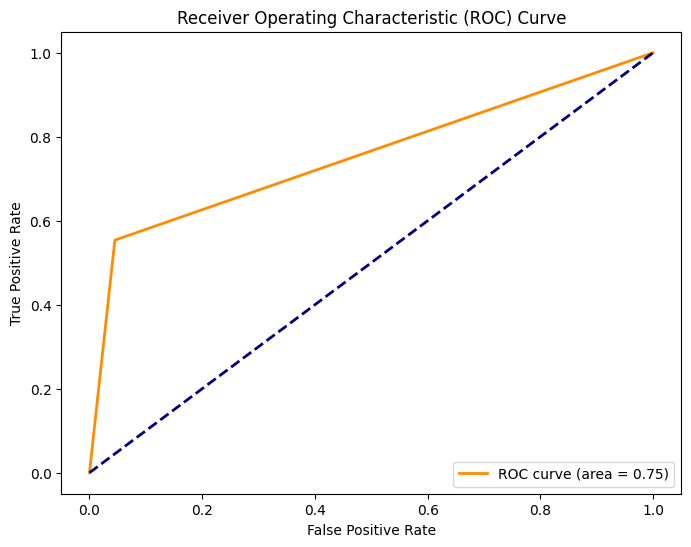

In [95]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



4) XGBoost Classifier

Best score of XGBoost: 0.9325146078156908
-------------------------------
F1 Score on Train Set: 0.7143367894172328
F1 Score on Test Set: 0.6522988505747126
-------------------------------
ROC-AUC Score on train: 0.8108591355363561
ROC-AUC Score on Test: 0.7767971449611965
------------------------------
------------------------------
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      2085
           1       0.72      0.60      0.65       381

    accuracy                           0.90      2466
   macro avg       0.82      0.78      0.80      2466
weighted avg       0.90      0.90      0.90      2466



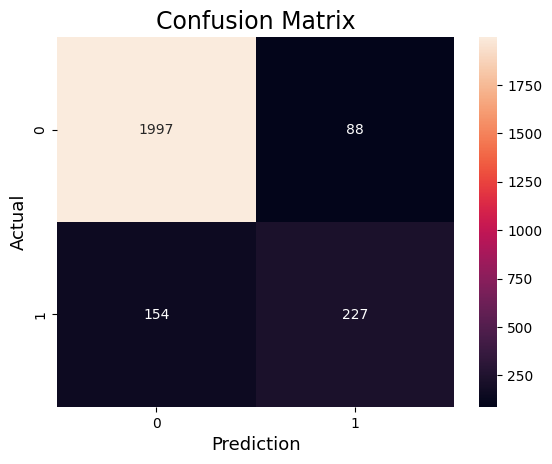

In [96]:
model = xgb.XGBClassifier()

xgb_param_grid = {'n_estimators': [100, 200, 300],
                    'max_depth': [3, 4, 5],
                    'learning_rate': [0.1, 0.01, 0.001]}

st_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)

xgb_grid_search = GridSearchCV(model, param_grid = xgb_param_grid, cv = st_kfold, scoring = 'roc_auc', n_jobs = -1)
xgb_grid_search.fit(X_train_scaled, y_train)

best_xgb = xgb_grid_search.best_estimator_
model_instances.append(best_xgb)

y_pred_train = best_xgb.predict(X_train_scaled)
f1_train = f1_score(y_train, y_pred_train)

print('Best score of XGBoost:', xgb_grid_search.best_score_)

print('-------------------------------')

#F1
print('F1 Score on Train Set:', f1_train)

y_pred = best_xgb.predict(X_test_scaled)
f1 = f1_score(y_test, y_pred)
print('F1 Score on Test Set:', f1)

print('-------------------------------')
#ROC-AUC
roc_auc_train = roc_auc_score(y_train, y_pred_train)
roc_auc = roc_auc_score(y_test, y_pred)

print('ROC-AUC Score on train:', roc_auc_train)
print('ROC-AUC Score on Test:', roc_auc)

models['xgb'] = roc_auc

print('------------------------------')

roc_aucs.append(roc_auc_score(y_test, y_pred))
f1s.append(f1_score(y_test, y_pred))

print('------------------------------')

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred),
              annot=True,
              fmt='g',
              xticklabels=['0', '1'],
              yticklabels=['0', '1'])
plt.ylabel('Actual', fontsize=13)
plt.xlabel('Prediction', fontsize=13)
plt.title('Confusion Matrix', fontsize=17)
plt.show()

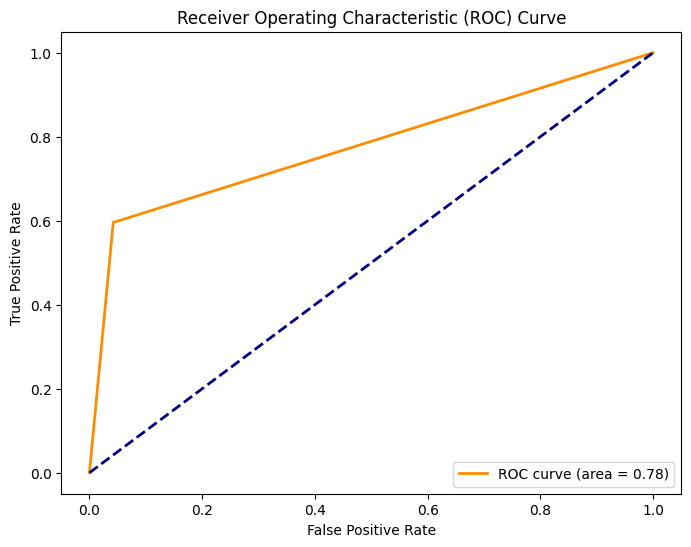

In [97]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Model evaluation

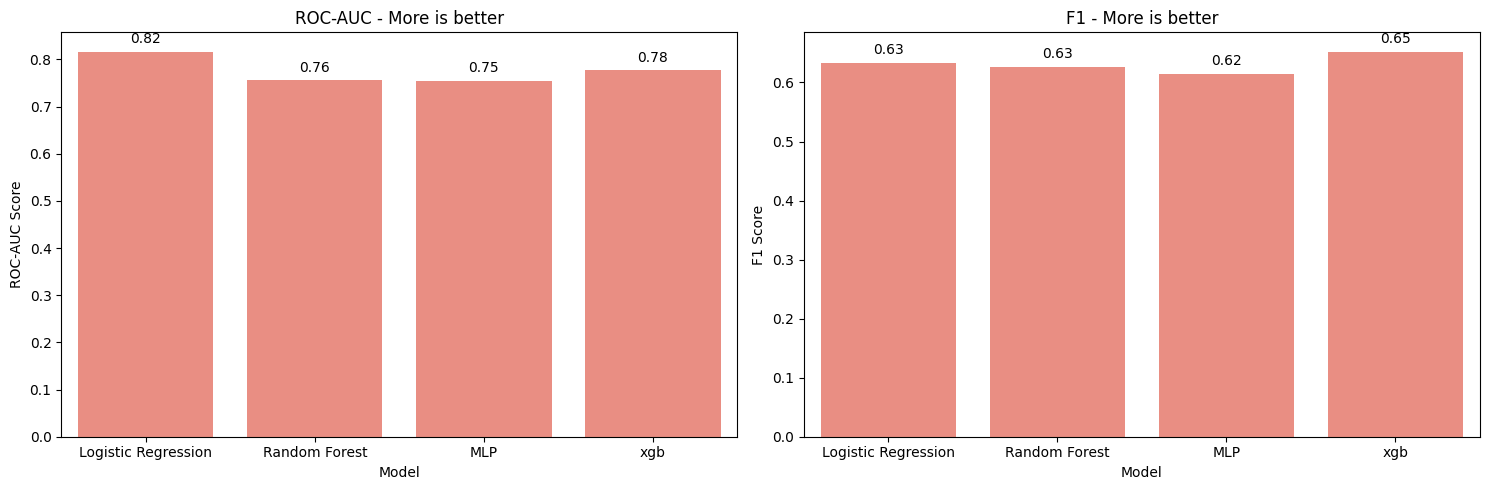

In [98]:

# Extraer categorías y valores
categories = list(models.keys())
roc_auc_values = list(models.values())

# Crear la figura y los ejes
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ROC-AUC
barplot_roc_auc = sns.barplot(x=categories, y=roc_auc_values, ax=axes[0])
axes[0].set_title('ROC-AUC - More is better')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('ROC-AUC Score')

# Añadir etiquetas con los puntajes sobre las barras
for bar in barplot_roc_auc.patches:
    axes[0].annotate(format(bar.get_height(), '.2f'),
                     (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                     ha='center', va='center',
                     xytext=(0, 9),
                     textcoords='offset points')

# F1
barplot_f1 = sns.barplot(x=categories, y=f1s, ax=axes[1])
axes[1].set_title('F1 - More is better')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('F1 Score')

# Añadir etiquetas con los puntajes sobre las barras
for bar in barplot_f1.patches:
    axes[1].annotate(format(bar.get_height(), '.2f'),
                     (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                     ha='center', va='center',
                     xytext=(0, 9),
                     textcoords='offset points')

# Mostrar el gráfico
plt.tight_layout()

print("""Teniendo en cuenta ambas metricas me voy a quedar con la regresion logistica""")


plt.show()



In [77]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

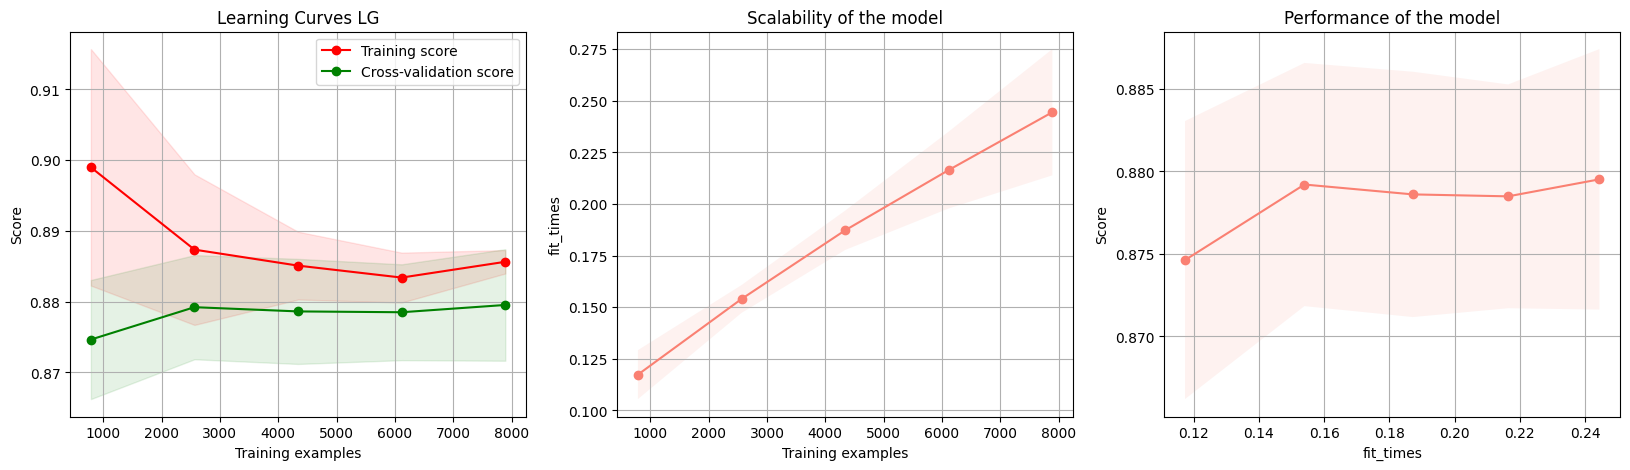

In [99]:
X, y = X_train, y_train

title = "Learning Curves LG"

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

estimator = best_log

plot_learning_curve(
    estimator, title, X, y, cv=cv, n_jobs=4,scoring="roc_auc"
)

plt.show()

El modelo final entonces es la Regresion logistica

Resultados finales:
- Score en cross validation: 0.88755
- ROC-AUC en train: 0.817794
- ROC-AUC en test: 0.816475
- F1 en train: 0.625067
- F1 en test: 0.63381

Se confirma nuestra hipotesis previa al entenamiento, la feature mas importante es "PageValues", que era la mas correlacionada con el target


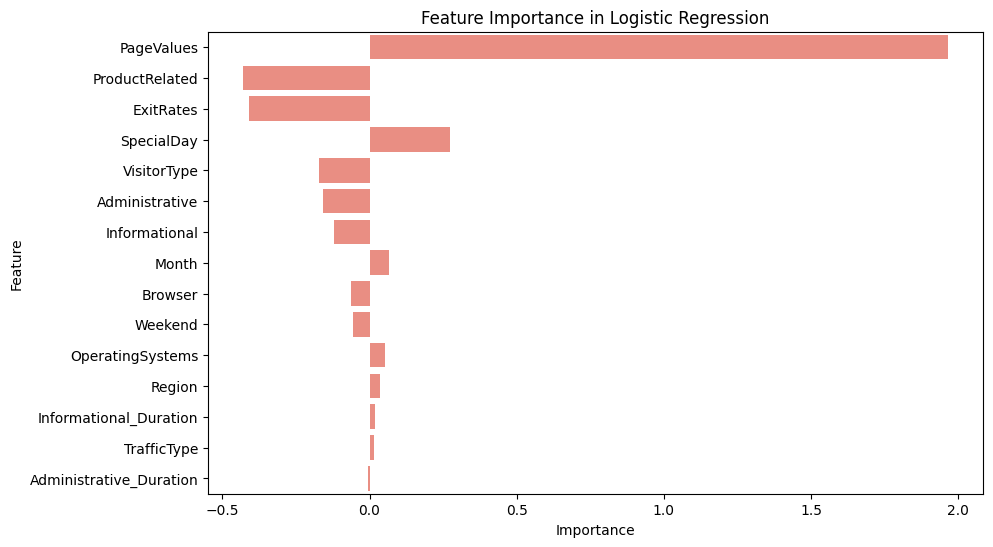

In [104]:
# Imprimimos la importancia de las variables
coefficients = best_log.coef_[0]

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': coefficients
})

# Ordenar por importancia absoluta
feature_importance['Abs_Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Importance', ascending=False)

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance in Logistic Regression')

print('Se confirma nuestra hipotesis previa al entenamiento, la feature mas importante es "PageValues", que era la mas correlacionada con el target')
plt.show()

### Preguntas teoricas

- ¿Es bueno el modelo?
Si, es bueno, predice con buena precision dado el caso de uso generico y generaliza bien en el test. Se podrian haber conseguir mejores resultados probablemente con mas features tienendo mas tiempo de hacer feature engineering o tecnicas de data augmentation.
Pero a grandes razgos el modelo es bueno, predice con casi un 90% de precision bajo la matrica ROC-AUC. Como se aclaró arriba, depende del caso de uso del modelo se deberia hacer uso de una u otra metrica y poner foco en ello.

- ¿Existe overfit o underfit?
Para responder esto se debe recordar que existe generalmente un trade-off entre bias (underfit) y variance (overfit).
Se produce Overfit cuando el modelo no es capaz de generalizar bien sobre otros datos que no sean los del entrenamiento, mientras que se produce Underfit cuando ni siquiera generaliza bien los del entrenamiento.
Pero generalmente al aprender muy bien sobre los datos de entrenamiento se suele dar una peor generalizacion sobre otros datos diferentes, lo que hace que el modelo no sea util pese las buenas metricas iniciales.

Considerando esto, dadas las metricas del modelo, no existe overfit, ya que es capaz de generalizar bien los datos que no vio durante su entrenamiento. Podria llegar a ajustarse mas, por lo que se podria argumentar la existencia de un underfit, pero yo argumento que no hay señales de underfit tampoco. En conclusion, es un buen modelo que no presenta overfit ni underfit dados los datos utilizados para entrenar y testear